In [1]:
# ** CMSC 320 UMD**
# *Project 2*
## **Author : Franklin Nkokam Ngongang**
### Due date : March 26, 2021
### Email : fnkokamn@terpmail.umd.edu
### UID : 117548327

In [2]:
import sqlite3
import pandas 
from matplotlib import pyplot as plt
import os
sqlite_file = 'lahman2014.sqlite'
backup_database_file = 'blabladb.sqlite'
conn = sqlite3.connect(sqlite_file)


Pre-required data.
This part was added last. Due to running several queries. we found out that we will need access to a list of team ids for this project. We will therefore load the team ids into a list, and reuse that list everyt time.

In [3]:
select_team_details_query = " SELECT DISTINCT T.name , T.teamId from Teams as T ORDER BY T.name"
team_details_result = pandas.read_sql(select_team_details_query, conn)

In [4]:
team_details_result.columns

Index(['name', 'teamID'], dtype='object')

In [5]:
team_names = [] # saving the team names in a list
team_ids = []
for index, row in team_details_result.iterrows():
    team_id = str(row['teamID']) # the team ID should be in string format
    team_name = str(row['name']) # The name should also be in a string format
    if not(bool(str(team_id))) == False:
        team_ids.append(team_id)
        team_names.append(team_name)

### ** Part 1 : Wrangling **

We need to compute the total payroll and winning percentage for each team.
The total payroll will be a sum of salaries in the salaries table, grouping by the teamId or grouping by yearID, depending if we want to view per team or per year.
The winning percentage is as defined the number of wins divided by number of games played(not games played at home), all multiplied by 100. Now we already have the list of team ids saved in a list. We can find that total payroll and winning percentage for each team by looping through that list of eam ids

In [6]:
working_query = "SELECT Teams.name as `TEAM NAME`, Salaries.teamID as `TEAM ID`, " + \
        "printf('%5.2f %',((SUM(Teams.W)*1.0)/(SUM(Teams.G)*1.0))*100.0) AS `WINNING PERCENTAGE`, " + \
        "printf('$%,d',SUM(Salaries.salary)) AS `TOTAL PAYROLL` " + \
        "FROM Salaries " + \
        "LEFT JOIN Teams ON Salaries.teamID = Teams.teamID " + \
        "GROUP BY `TEAM ID` " + \
        "ORDER BY `TEAM NAME`,`TEAM ID` "
query_result = pandas.read_sql(working_query, conn)
#query_result

In [7]:
query_result

,TEAM NAME,TEAM ID,WINNING PERCENTAGE,TOTAL PAYROLL
0,None,NYM,0.00 %,"$54,806,990"
1,None,SFG,0.00 %,"$143,510,167"
2,Anaheim Angels,ANA,51.23 %,"$3,744,735,784"
3,Arizona Diamondbacks,ARI,49.20 %,"$20,569,578,876"
4,Atlanta Braves,ATL,51.76 %,"$92,264,392,416"
5,Baltimore Orioles,BAL,51.23 %,"$99,442,202,318"
6,Boston Red Sox,BOS,51.43 %,"$277,327,906,590"
7,California Angels,CAL,48.24 %,"$8,703,325,760"
8,Chicago White Sox,CHA,50.18 %,"$193,784,626,302"
9,Chicago White Stockings,CHN,50.70 %,"$258,516,830,785"


#### Explanation of the working_query 

The first line selects the tteam id found in the Salaries table.
The next line calculates the percentage wins. Here we multiply the sums by 1.0 to make sqlite convert it to floating points number, else the division operator will return zero for every sum of wins over sum of total games played, since the division operator returns zero if an numerator is divided by an denominator when the numerator is less than the denominator.
The next line calculates the total salary paid to players for that particular team for a specific year. It uses the printf function to format the data to 5 spots(including the dot character) : two decimal places, and two places before the decimal like the C printf function would do. It's just a semi replica of the c printf function.
The next line tells sqlite from what tables to pull the data from, both from Salaries and Teams table. 
The next line specifies the mathematical joining clause. In this instancd the left join clause.

#### Dealing with the empty values

Let's examine the query above, more precisely the left join clause : 
SELECT Teams.name as `TEAM NAME`, Salaries.teamID as `TEAM ID`,
printf('%5.2f %',((SUM(Teams.W)*1.0)/(SUM(Teams.G)*1.0))*100.0) 
AS `WINNING PERCENTAGE`,    
printf('$%,d',SUM(Salaries.salary)) AS `TOTAL PAYROLL`    
FROM Salaries    
LEFT JOIN Teams ON Salaries.teamID = teams.teamID    
GROUP BY `TEAM ID`    
ORDER BY `TEAM ID` 

The left join line tells sqlite to pull out results from the Salaries tables, and the teams table, for each row such that the team id for that row in the Salaries table is being foreign-keyed by a team id from the Teams table. So what this means is that the we want the results to be in such a way that we only see results when the team id is found in the Salaries table. Now in our case, every row in the Salaries table has a team id that comes from the Teams table. Now some teams might not have any rows in the salaries table. So doing a left join on the Salaries table instead will bring out some null values. But doing a left join on the Teams table will not bring out any nulls unless there are team ids in the Salaries table that have no teams in the Teams table, which does not make sense.

To find out where the empty sets come from, we decided to search for any team in the Salaries table that does not have a row in the Teams table. Thinking about that, it's not supposed to be possible. But in this case it is. Let's have a look at that. First let's select team ids in the salary table that are not present in the teams table

In [8]:
surprise_query = "SELECT DISTINCT teamID FROM Salaries " + \
                 "WHERE teamID NOT IN (" + \
                 "SELECT DISTINCT teamID FROM Teams"  + \
                 " ) "
surprise_result = pandas.read_sql(surprise_query, conn)
surprise_result

,teamID
0,NYM
1,SFG


So there are two teams rows in the Salaries table not found in the Teams table.
Let's find their total payroll

In [9]:
further_query = "SELECT teamID, " + \
        "printf('$%,d',SUM(salary)) AS `TOTAL PAYROLL` " + \
        "FROM Salaries " + \
        "WHERE (teamID = 'NYM' OR teamID ='SFG') " + \
        "GROUP BY teamID " + \
        "ORDER BY teamID "
further_result = pandas.read_sql(further_query, conn)
further_result

,teamID,TOTAL PAYROLL
0,NYM,"$54,806,990"
1,SFG,"$143,510,167"


This results matches the two None teamId starting rows we have in the beginning of this part. An alternative will be to left join on Teams table instead.

In [10]:
good_query = "SELECT Teams.name as `TEAM NAME`, Salaries.teamID as `TEAM ID`, " + \
        "printf('%5.2f%',((SUM(Teams.W)*1.0)/(SUM(Teams.G)*1.0))*100.0) AS `WINNING PERCENTAGE`, " + \
        "printf('$%,d',SUM(Salaries.salary)) AS `TOTAL PAYROLL` " + \
        "FROM Teams " + \
        "LEFT JOIN Salaries ON Salaries.teamID = Teams.teamID " + \
        "GROUP BY `TEAM ID` " + \
        "ORDER BY `TEAM NAME`,`TEAM ID` "

In [11]:
good_result = pandas.read_sql(good_query, conn)
good_result

,TEAM NAME,TEAM ID,WINNING PERCENTAGE,TOTAL PAYROLL
0,Anaheim Angels,ANA,51.23%,"$3,744,735,784"
1,Arizona Diamondbacks,ARI,49.20%,"$20,569,578,876"
2,Atlanta Braves,ATL,51.76%,"$92,264,392,416"
3,Baltimore Orioles,BAL,51.23%,"$99,442,202,318"
4,Boston Americans,BOS,51.43%,"$277,327,906,590"
5,Boston Red Stockings,None,48.06%,$0
6,California Angels,CAL,48.24%,"$8,703,325,760"
7,Chicago White Sox,CHA,50.18%,"$193,784,626,302"
8,Chicago White Stockings,CHN,50.70%,"$258,516,830,785"
9,Cincinnati Reds,CIN,50.14%,"$179,346,918,500"


With this query above, we get a result without None values.

## **Part 2 : Exploratory Data Analysis**
### *** Payroll Distribution *** 

### *** Distribution of payrolls conditioned on time between the years 1990 and 2014 ***

For this section, we want to see how the payrolls distribute over time between 1990 and 2014. For that we will use a similar query to the query above.

In [12]:
payroll_query =  \
        "SELECT Salaries.teamID as `TEAM ID`, " + \
        "Salaries.yearID AS `YEAR`, " + \
        "SUM(Salaries.salary) AS `TOTAL SALARY PAID` " + \
        "FROM Salaries " + \
        "WHERE Salaries.yearID >= '1990' AND " + \
        "Salaries.yearID <= '2014' " + \
        "GROUP BY `TEAM ID`, `YEAR` " + \
        "ORDER BY `TEAM ID`, `YEAR` " 
payroll_result = pandas.read_sql(payroll_query, conn)
payroll_result.head()

,TEAM ID,YEAR,TOTAL SALARY PAID
0,ANA,1997,31135472.0
1,ANA,1998,41281000.0
2,ANA,1999,55388166.0
3,ANA,2000,51464167.0
4,ANA,2001,47535167.0


In [13]:
payroll_result.tail()

,TEAM ID,YEAR,TOTAL SALARY PAID
725,WAS,2010,61400000.0
726,WAS,2011,63856928.0
727,WAS,2012,80855143.0
728,WAS,2013,113703270.0
729,WAS,2014,131983680.0


Above is what the results will look like. So we need to plot the results for all the years. We could do it as a query, then plot it. This will require manipulating the dataframe to pick the salaries paid per team for each year. That is tedious, when sql can do the job for us in case we have the team IDs in a list.
So a better way is to have the list of teamIds and names in a python list, then make an sql query selection based on each value for that list, then plot the result for each team, since each value in the list will correspond to a unique team. Luckily at the begnining of this document, we selected the list of team ids and team names and stored them in a list.

In [14]:
# saving the result of running the read_sql function in a list
result_frames_objects = [] 

for index in range(len(team_ids)):
    team_id = str(team_ids[index]) # the team ID should be in string format
    team_name = str(team_names[index]) # The name should also be in a string format
    the_query = "SELECT SUM(salary) as `Total_Payroll`, " + \
                "AVG(salary) AS `Average_Payroll`, " + \
                "yearID as `Year` " + \
                "FROM Salaries " + \
                "WHERE teamID = '" + team_id + "' "  + \
                "AND yearID >= '1990' AND yearID <= '2014' " + \
                "GROUP BY yearID ORDER BY yearID "
   
    result_frames_objects.append(pandas.read_sql(the_query, conn))
    

#### Explaing the query above

We are selecting the total payrolls ad average payrolls for each year. 
That salary sum will be identified in the dataframe as Total_Payroll.  The where clause identifies the team for which the selection should be made, and the yearId should be between 1990 and 2014,inclusive.
The result will be saved in a list. We will iterate over that list to plot it. 

In [15]:
len(result_frames_objects) # checking if the list is not empty

185

In [16]:
len(result_frames_objects) # checking if the list is not empty


185

Now let's have fun plotting the results we just got. Whenever more than 20 figures will be plotted, a warning would be genrated about using too much memory. The results is to do this instruction : 
#### *_ plt.rcParams.update({'figure.max_open_warning':0})_*
Also we are plotting the logarithm of the y axis and not the y axis.

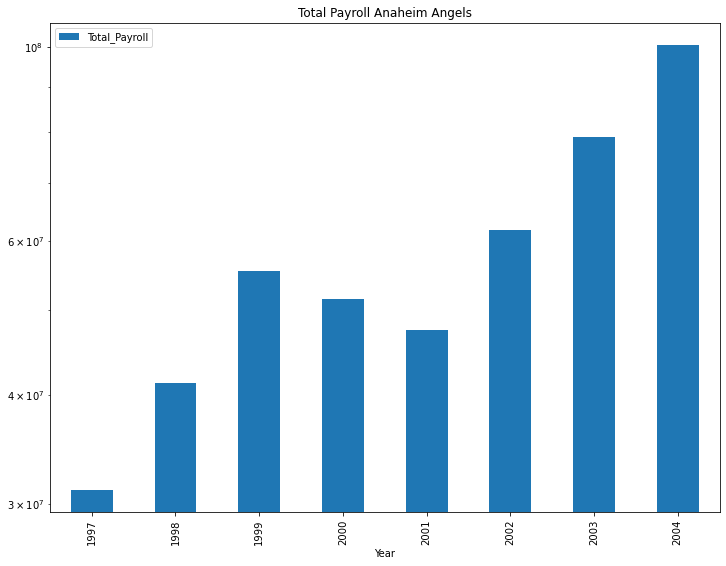

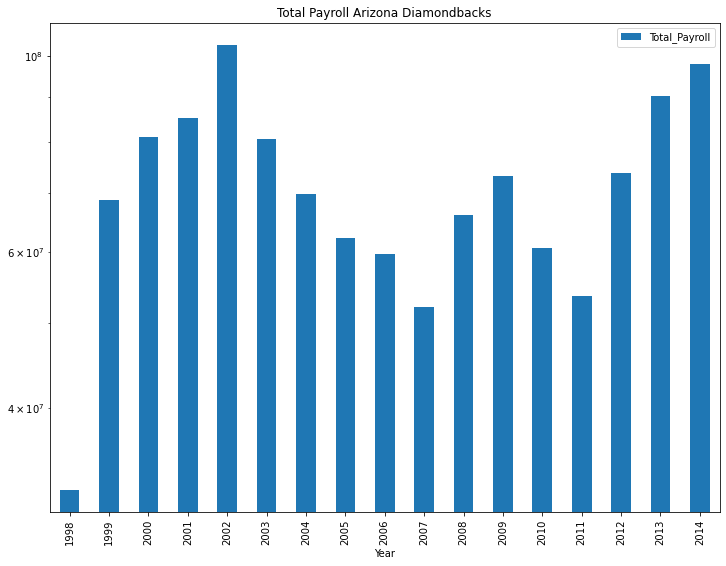

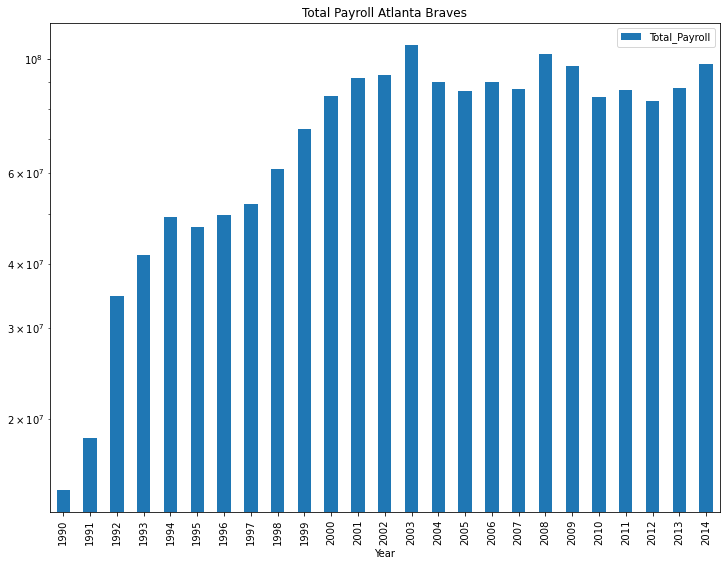

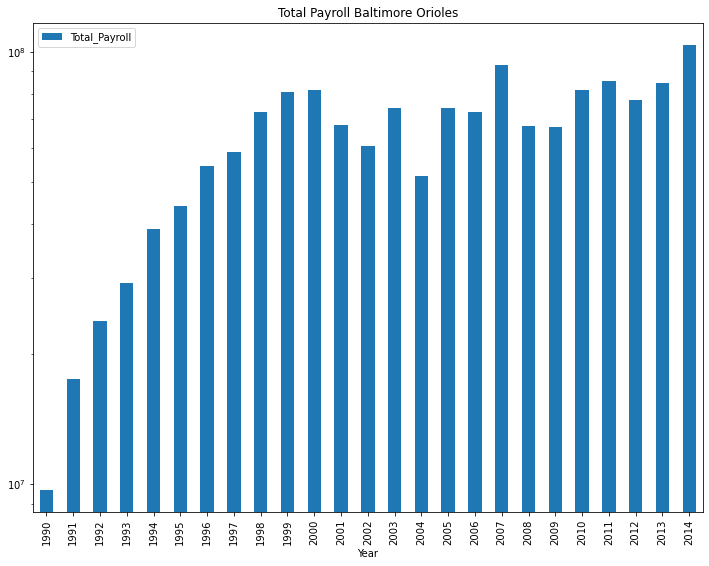

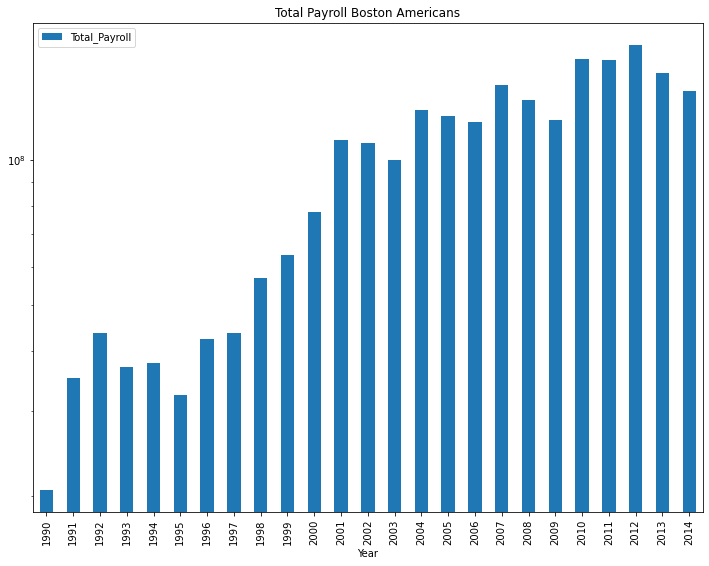

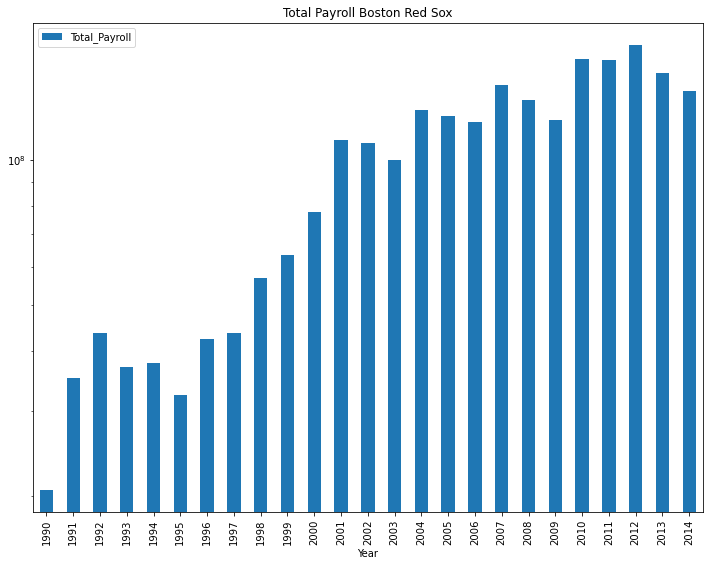

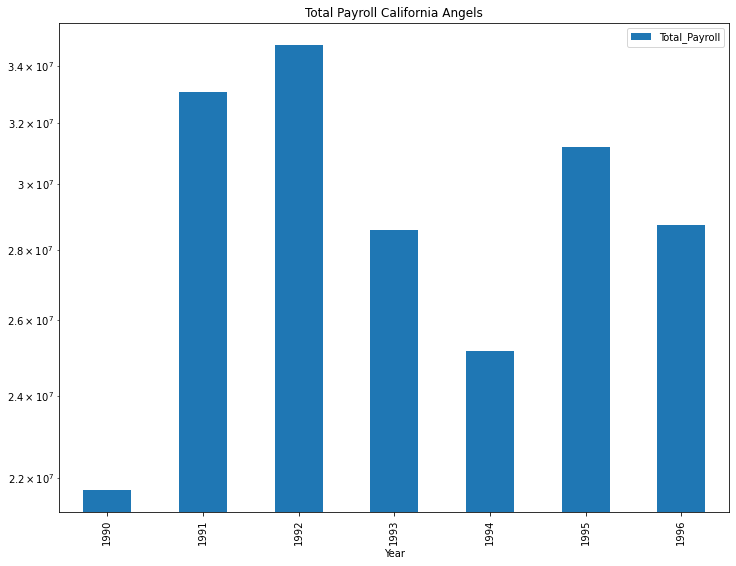

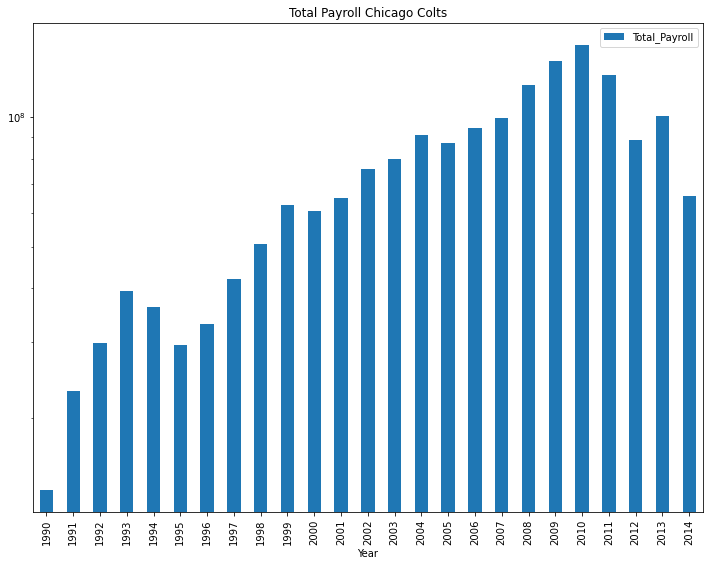

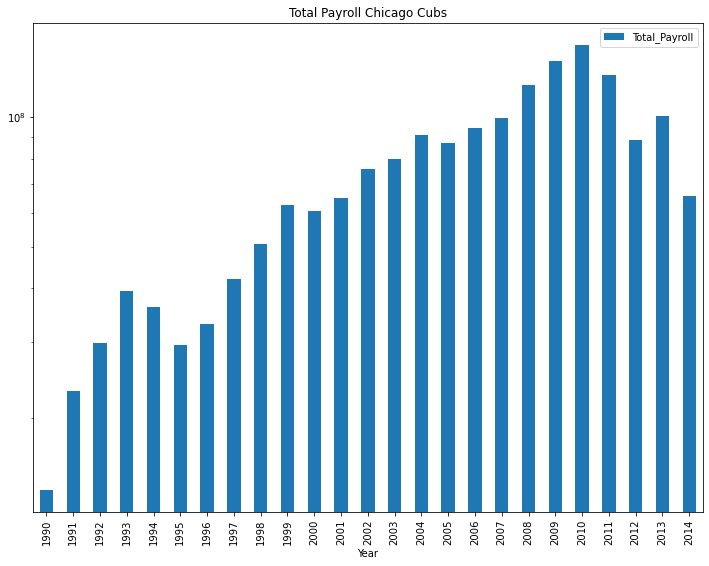

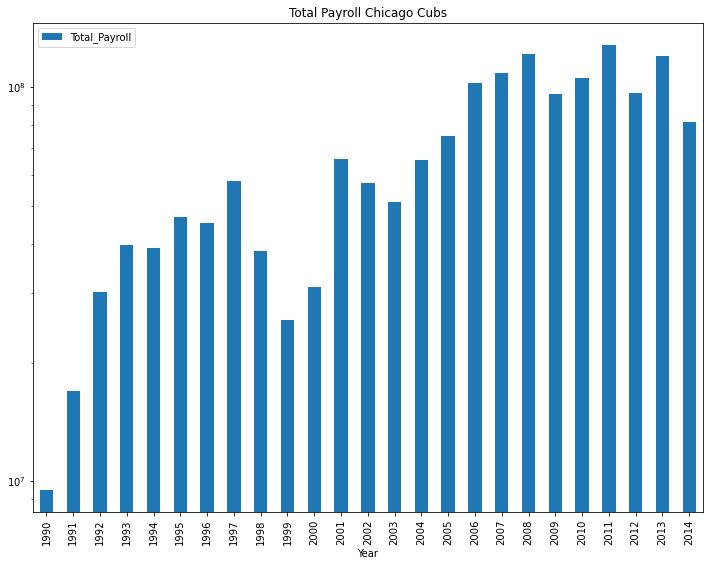

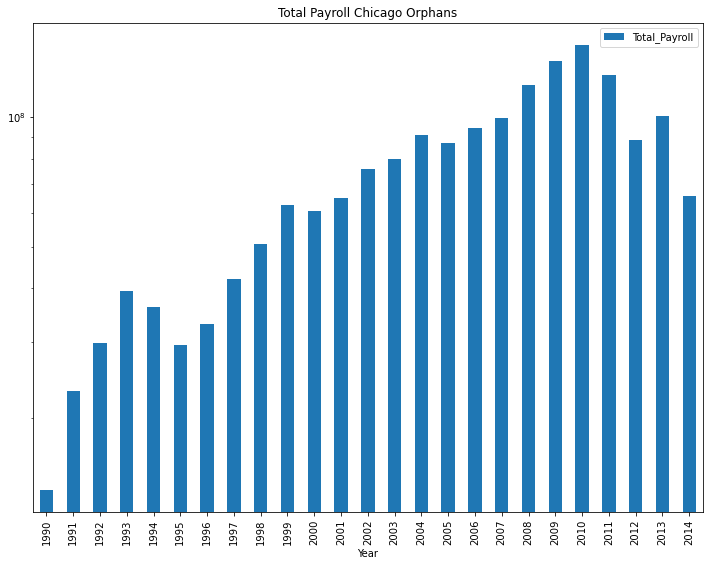

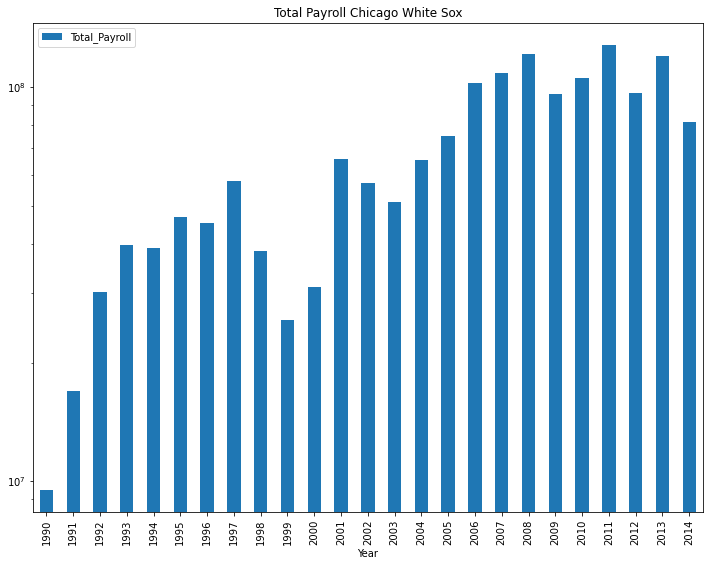

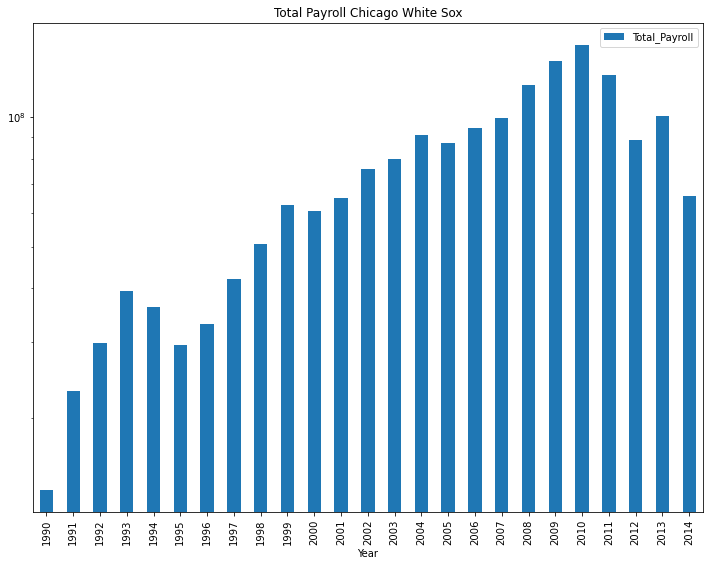

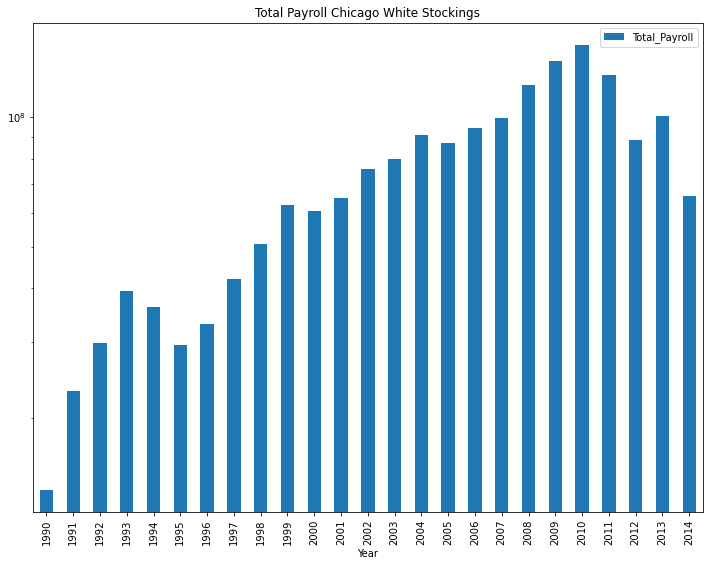

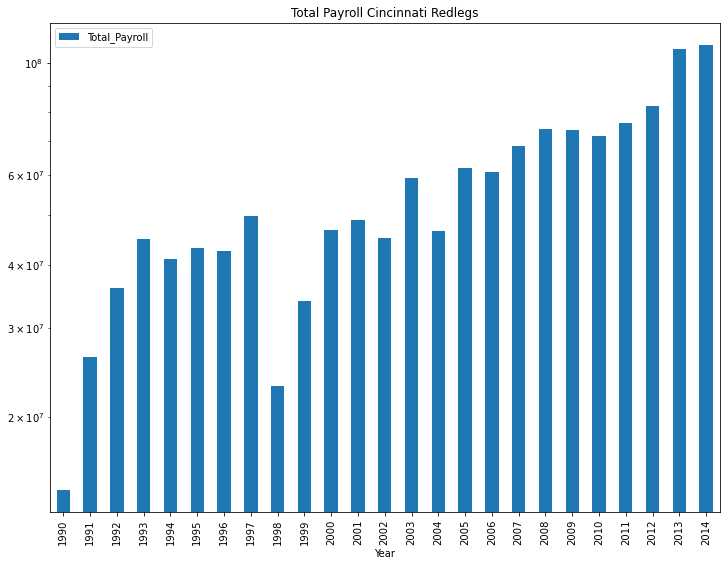

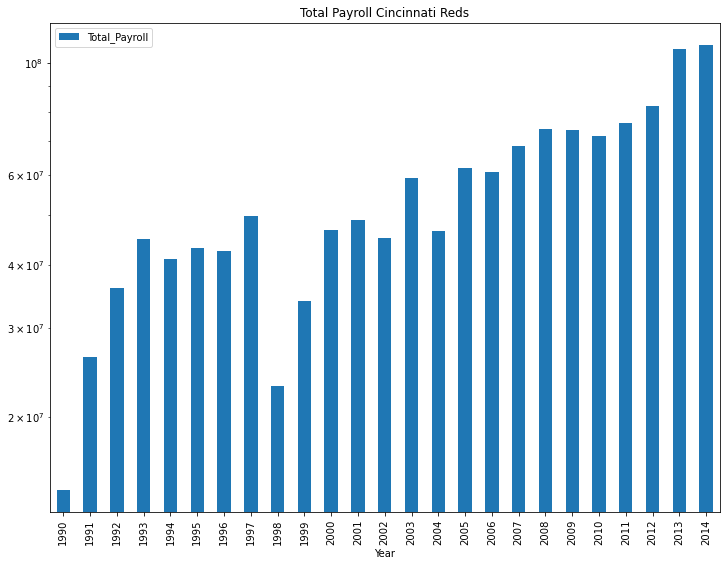

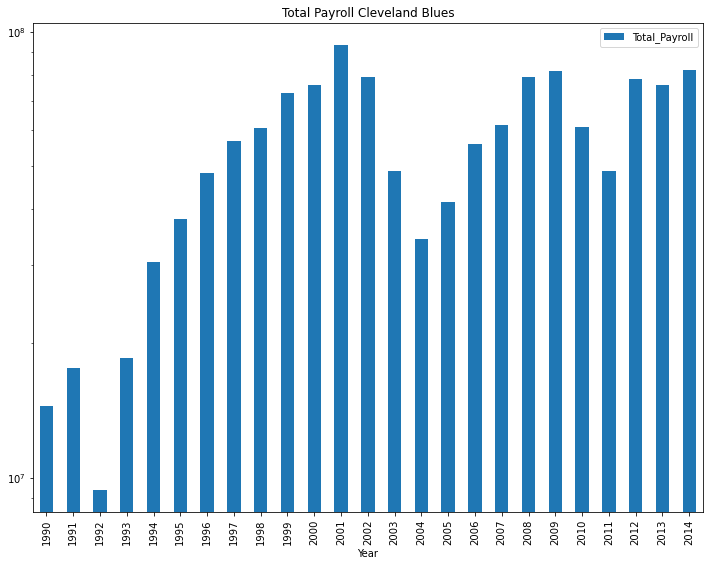

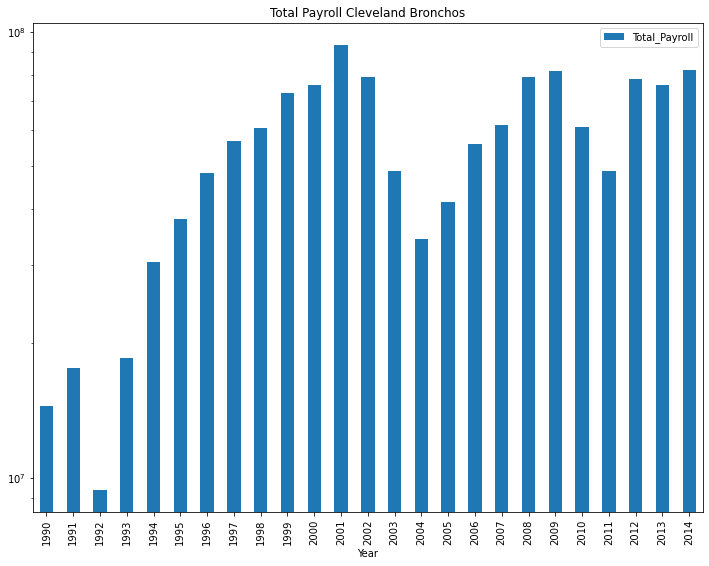

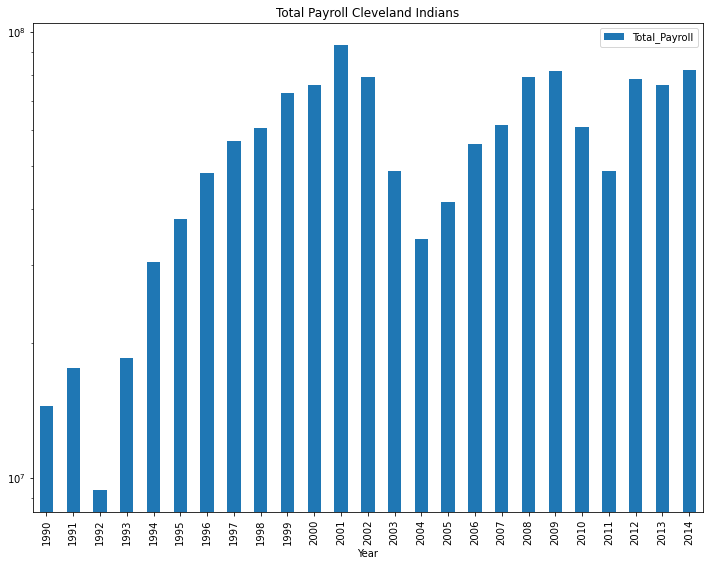

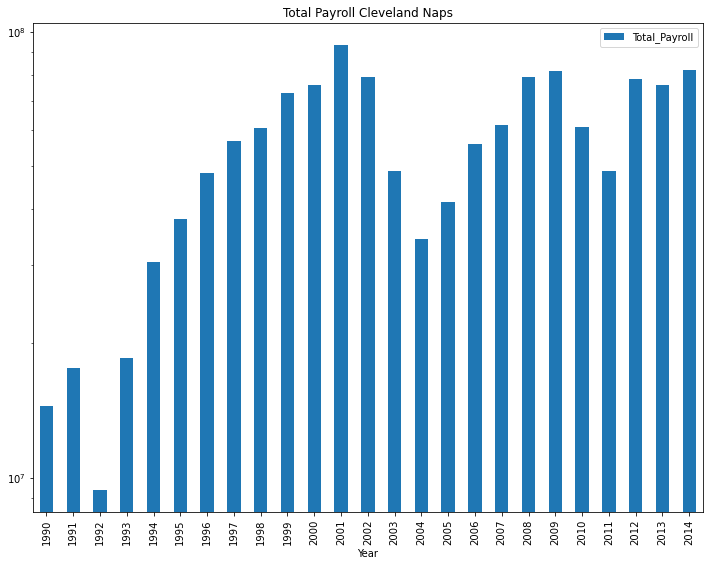

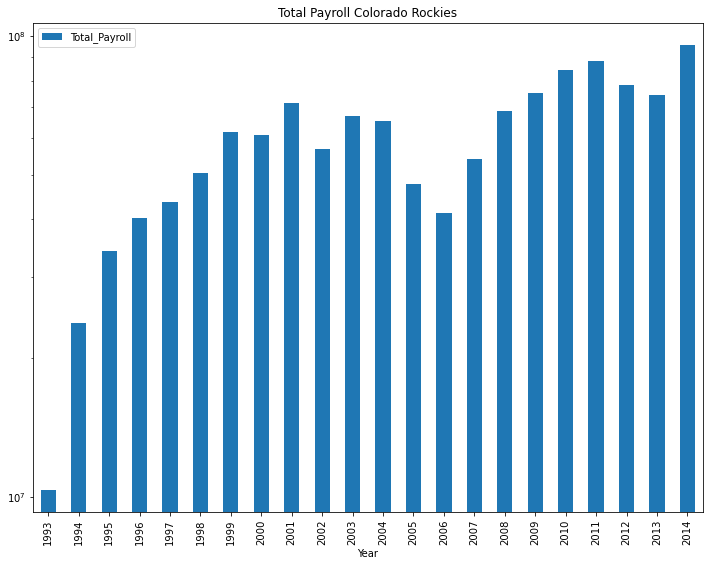

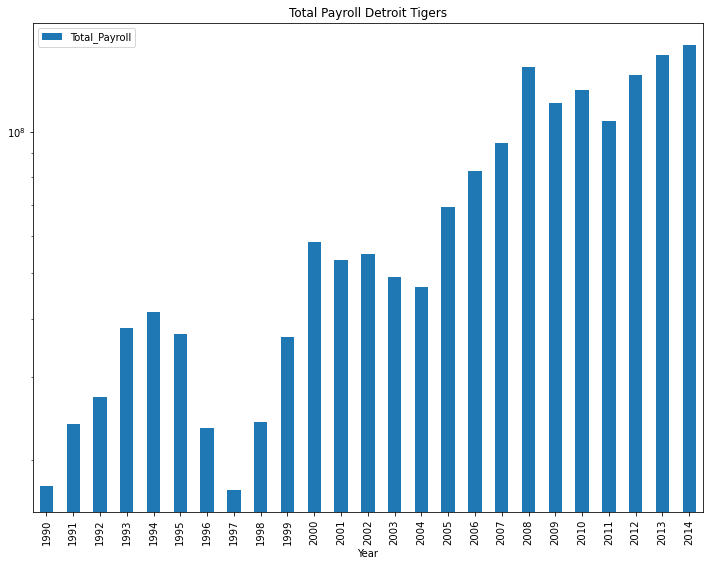

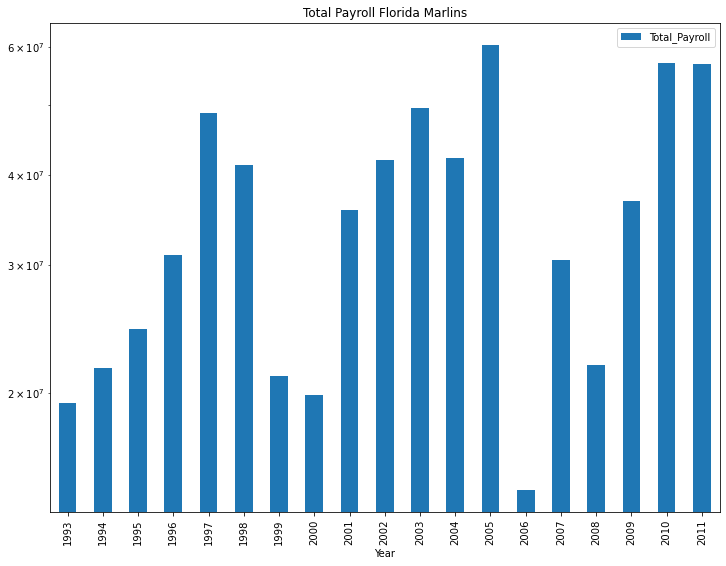

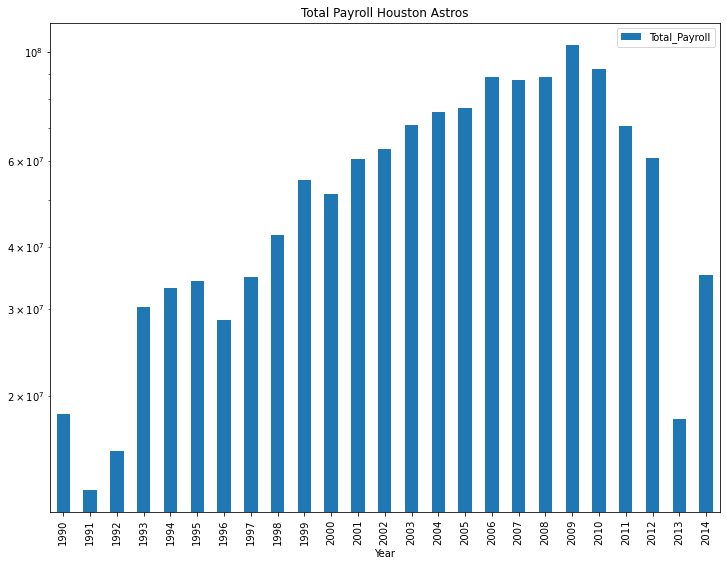

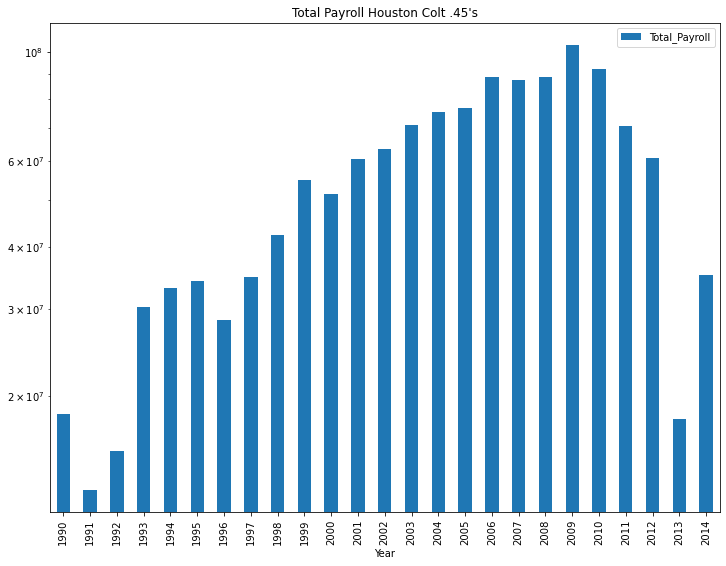

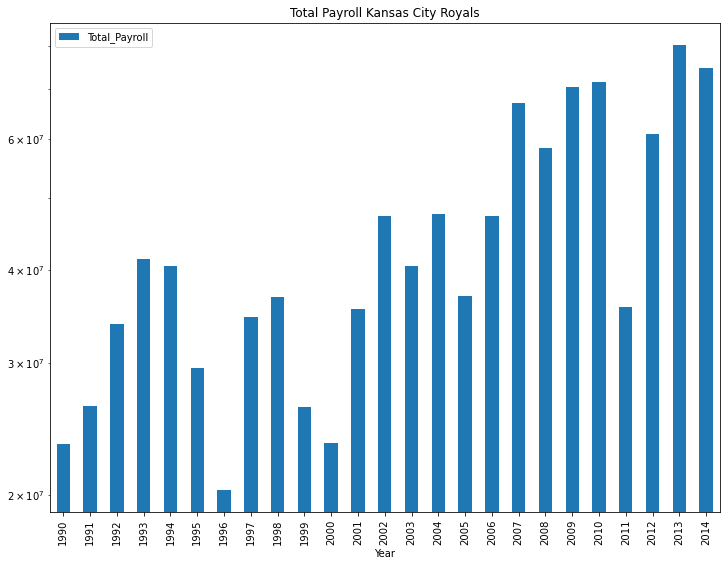

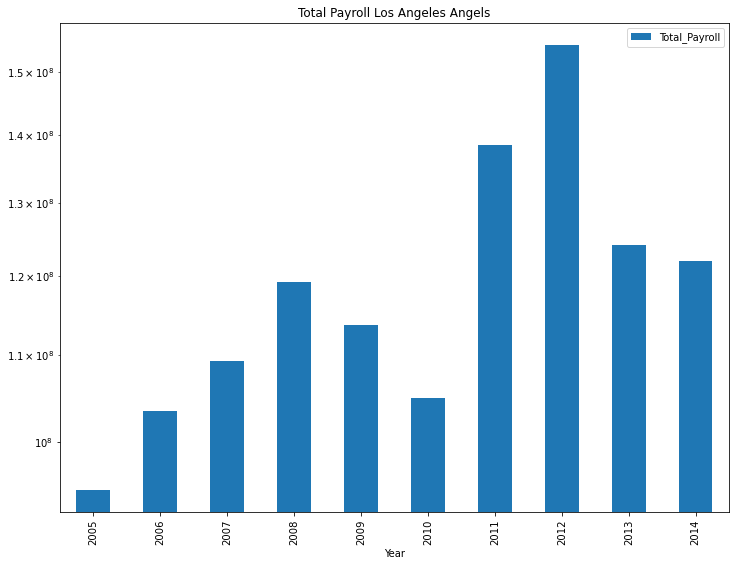

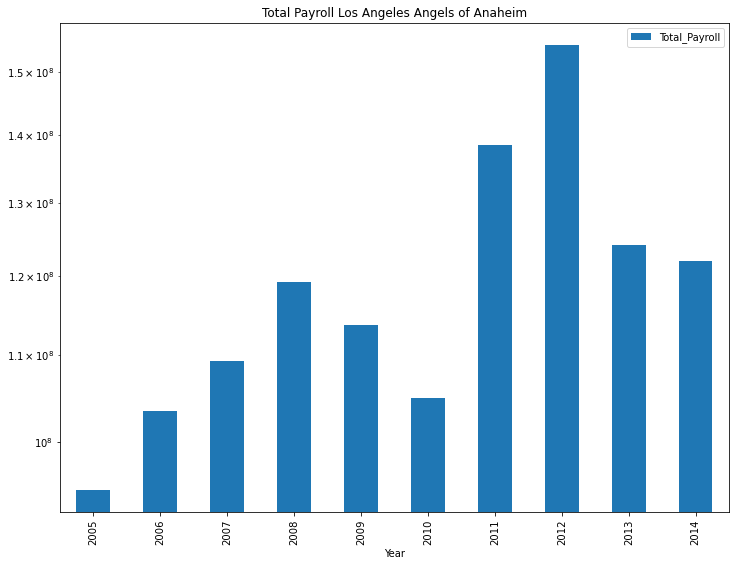

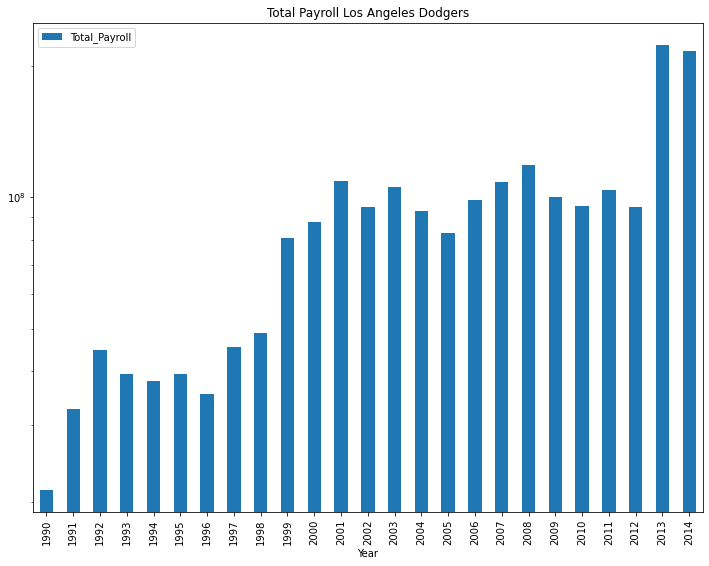

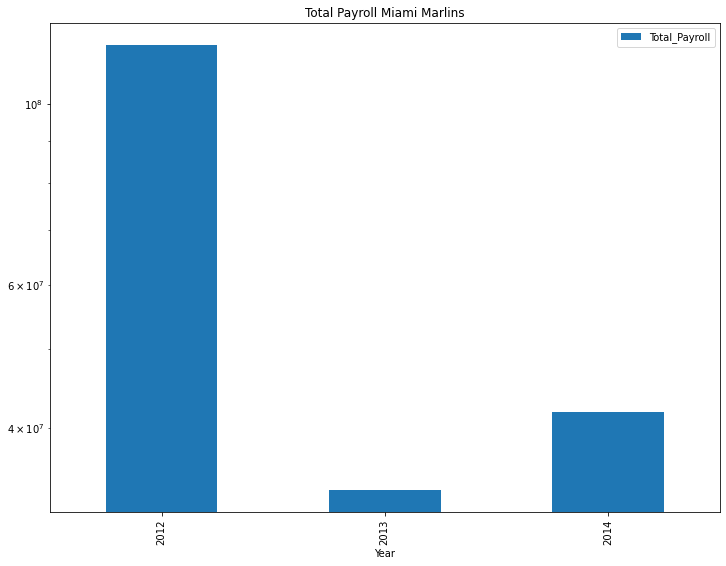

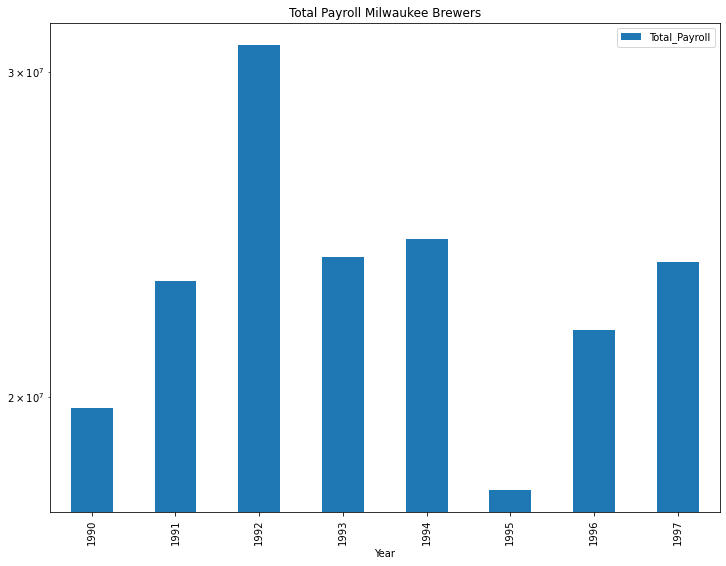

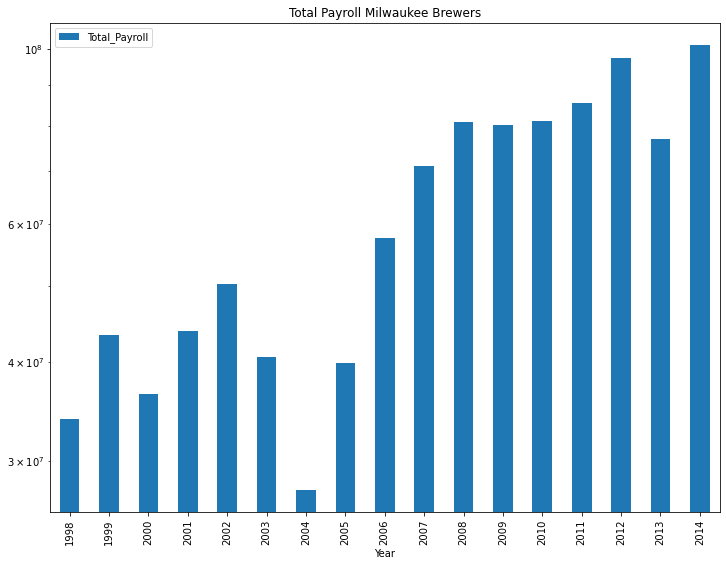

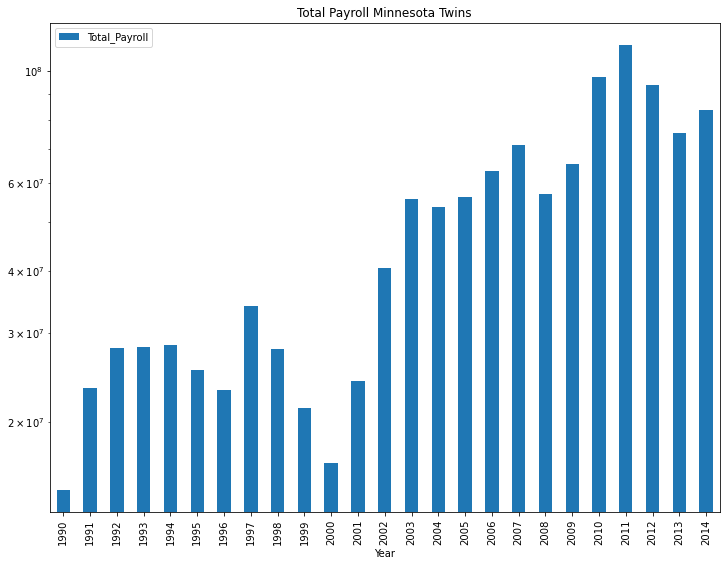

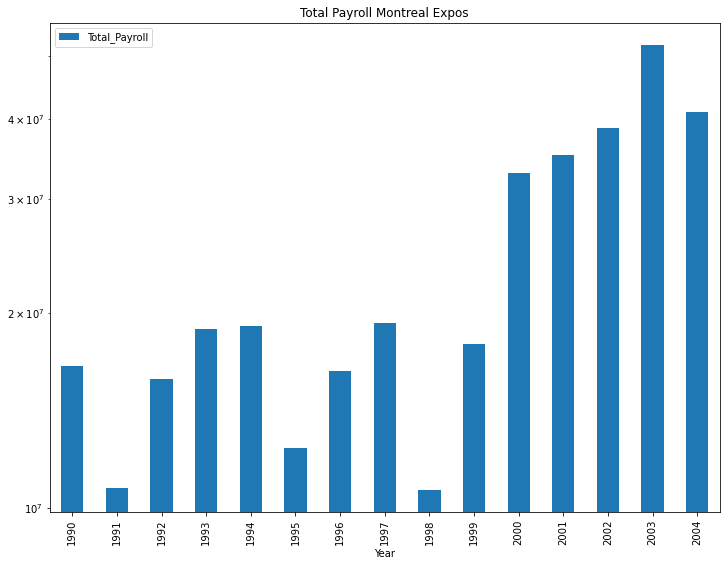

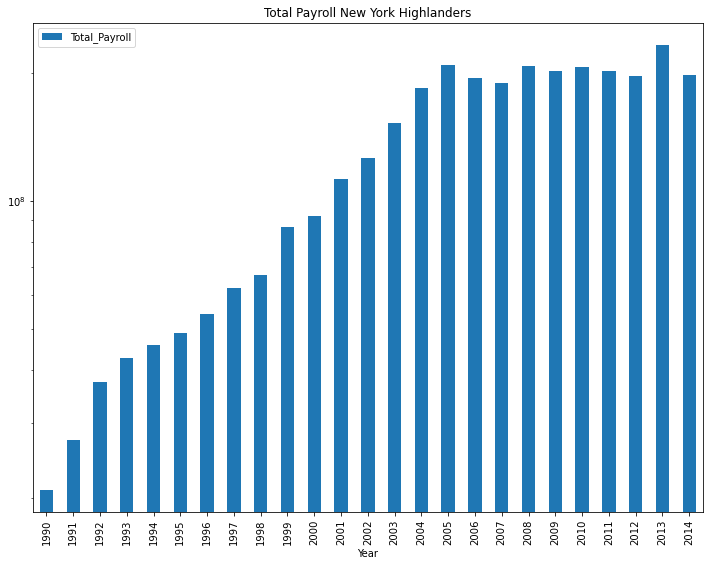

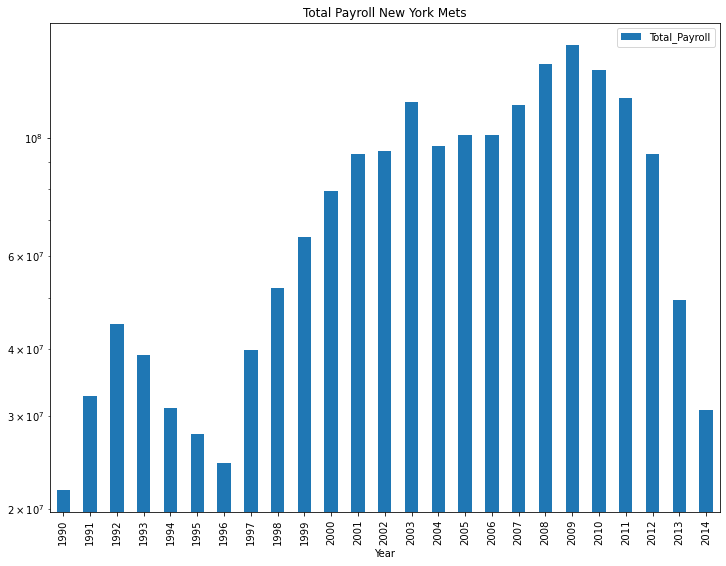

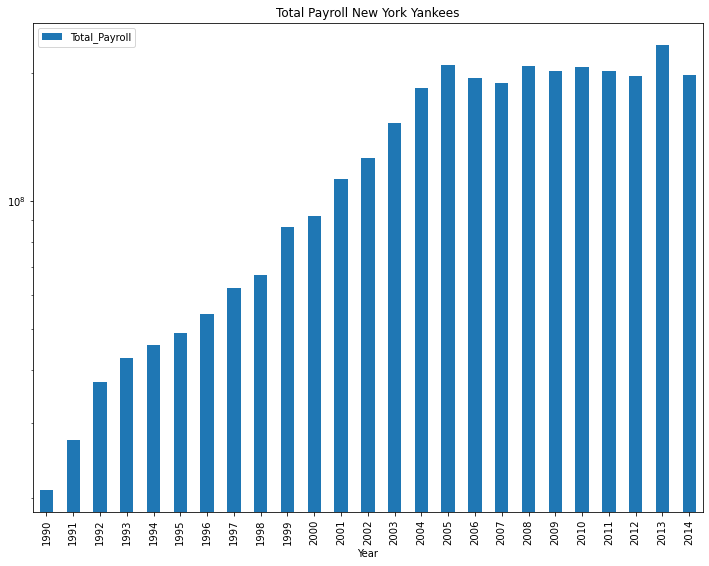

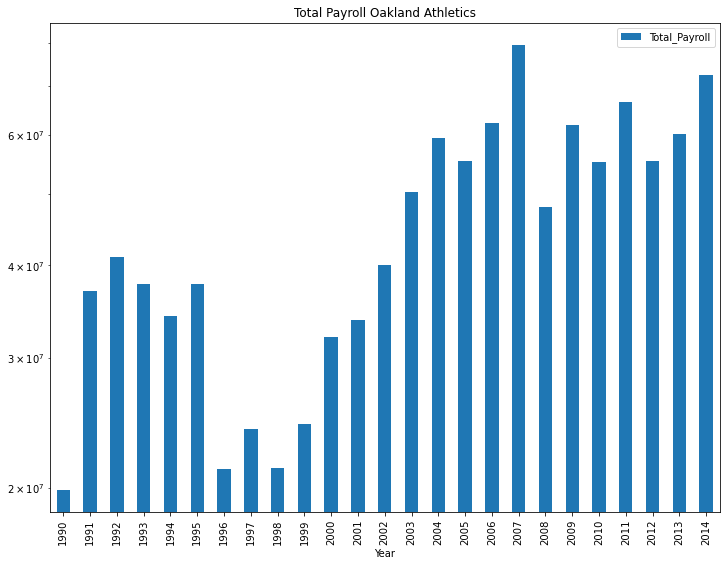

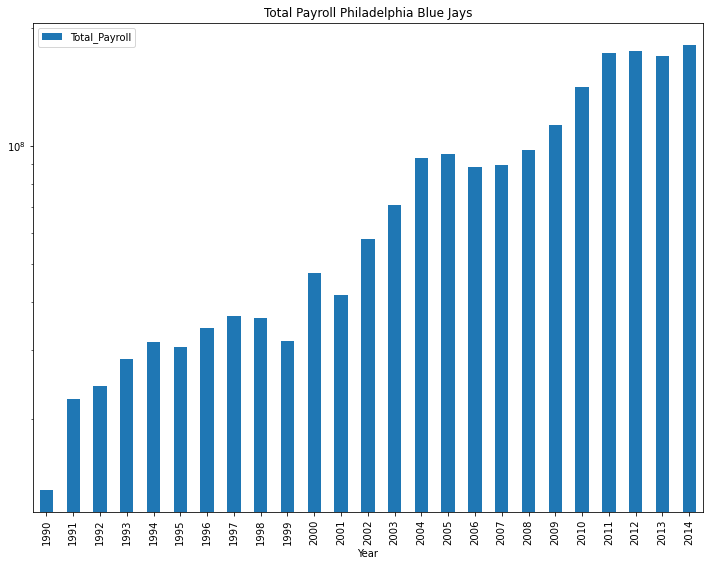

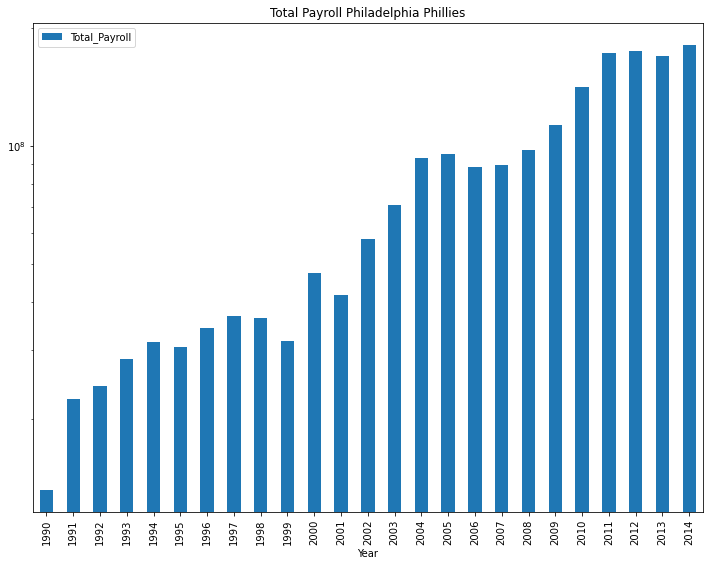

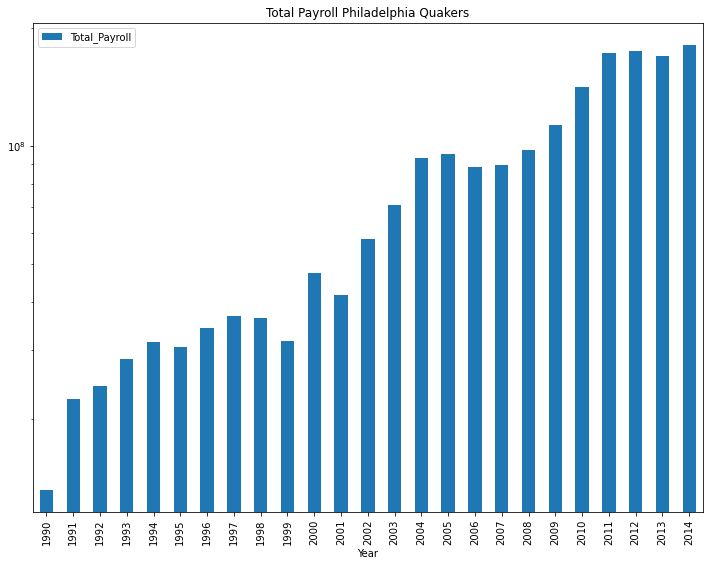

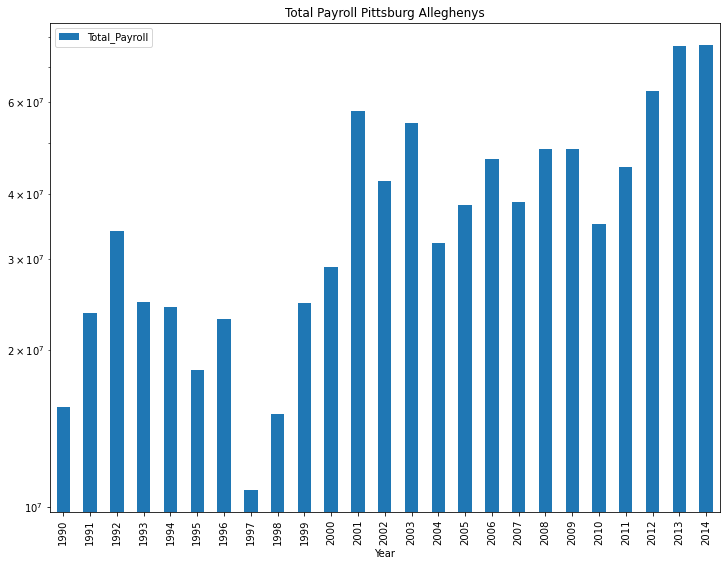

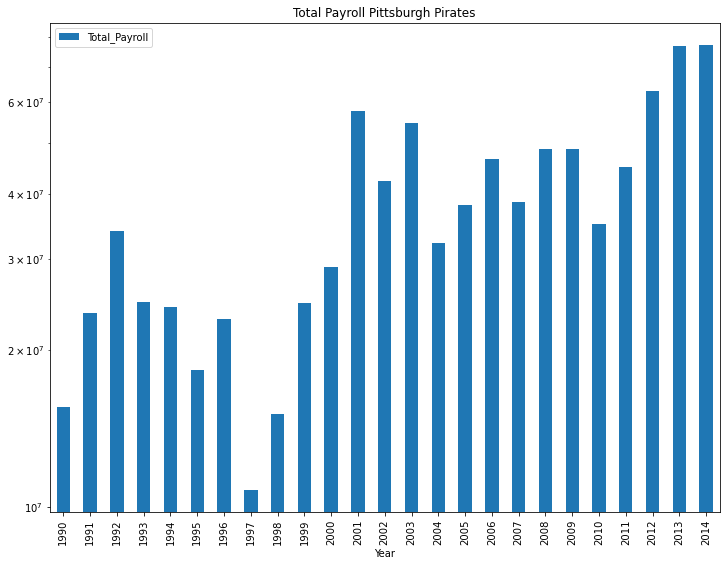

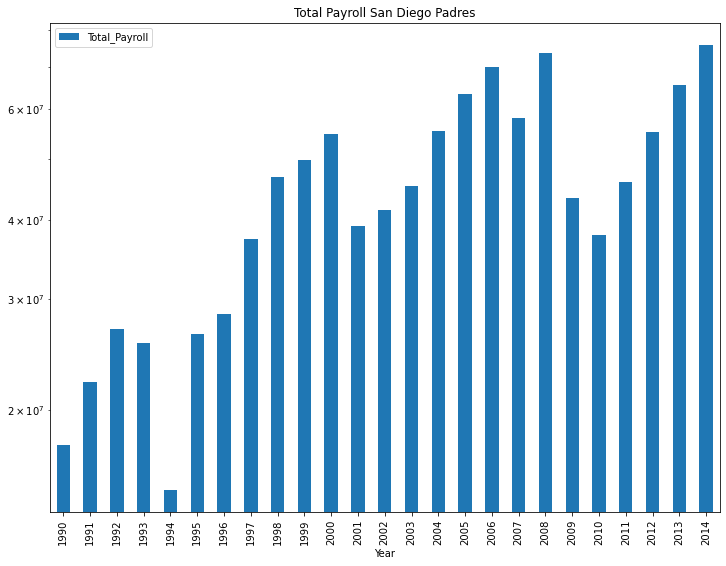

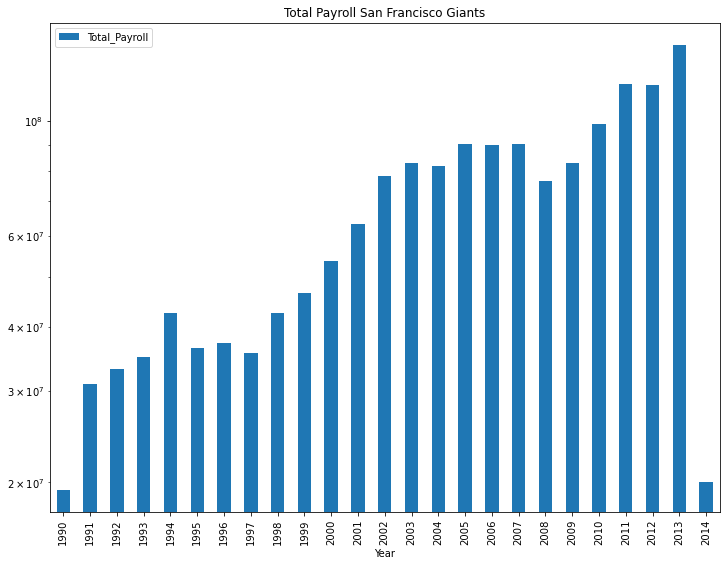

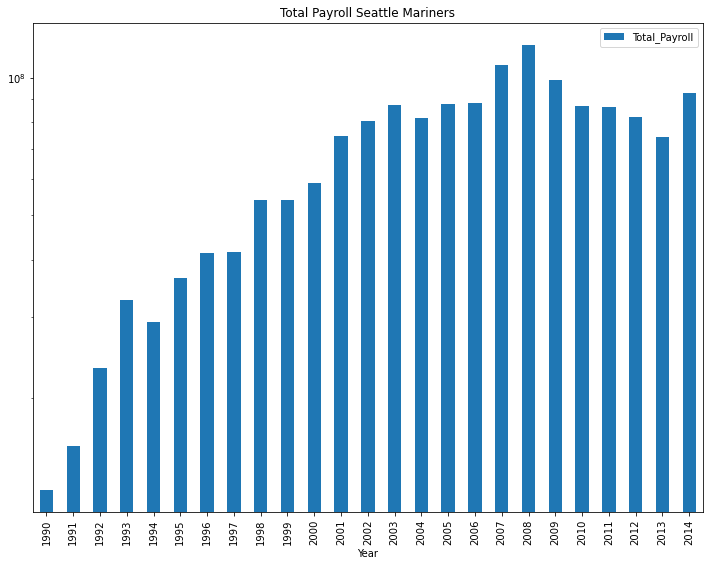

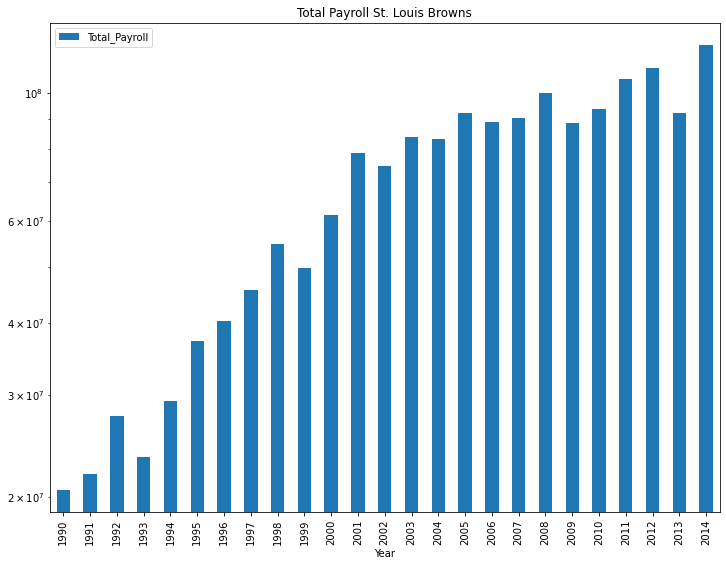

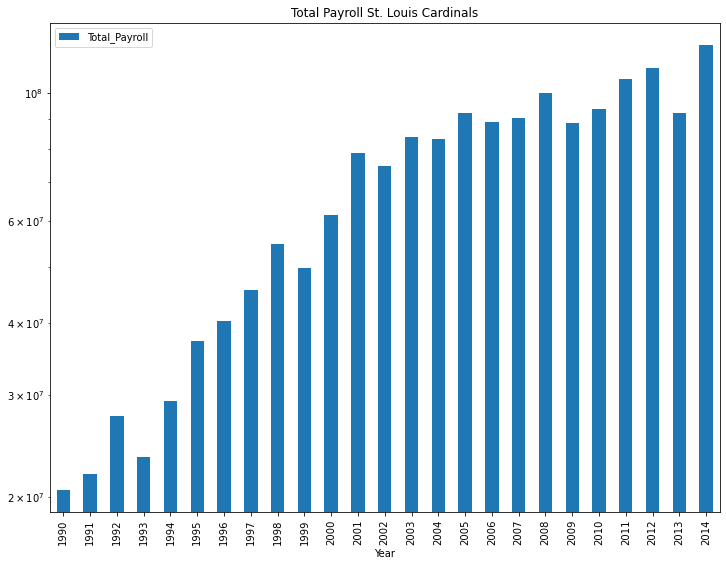

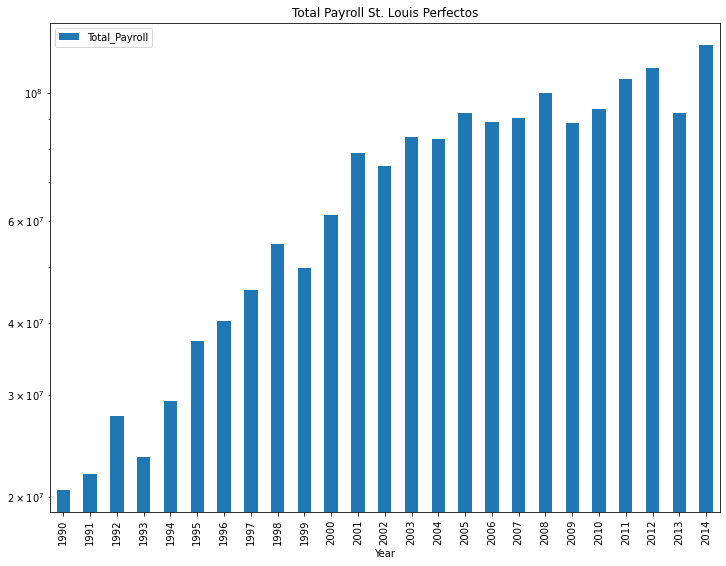

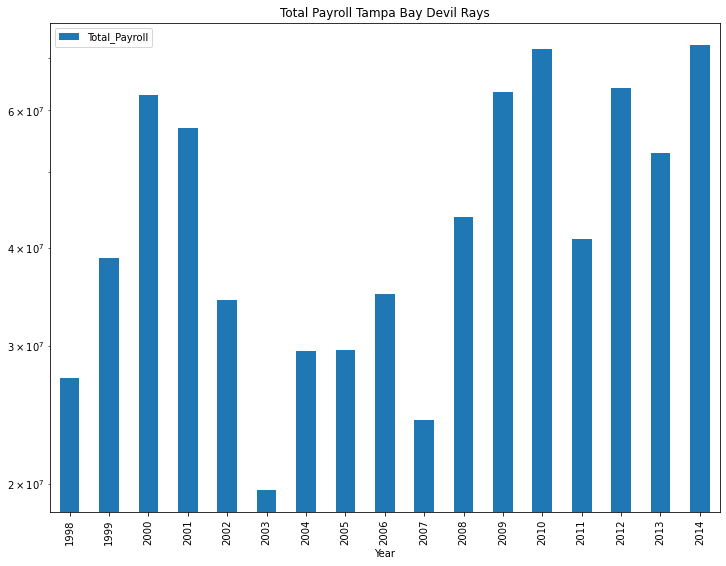

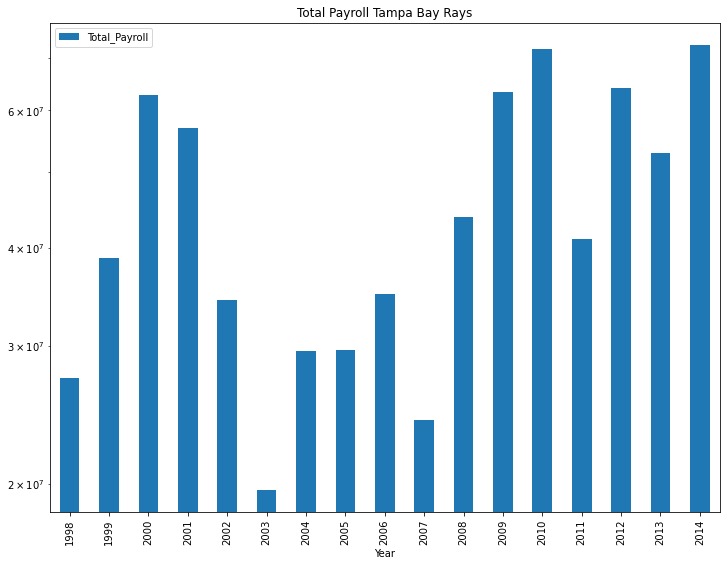

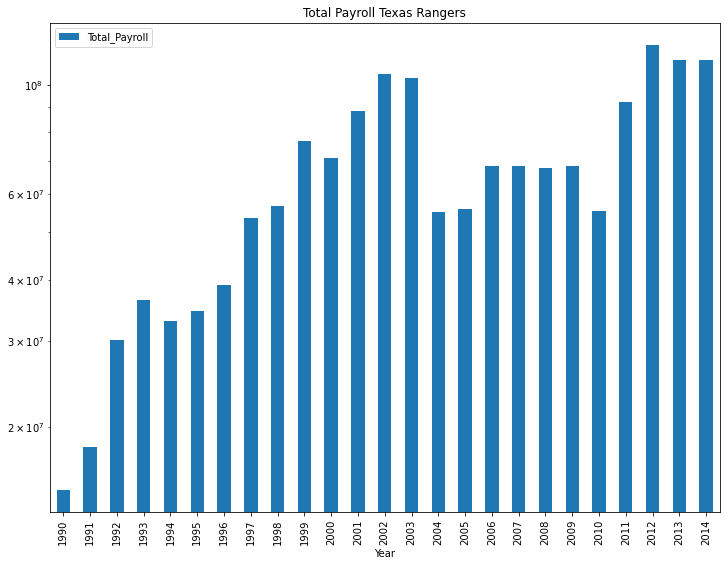

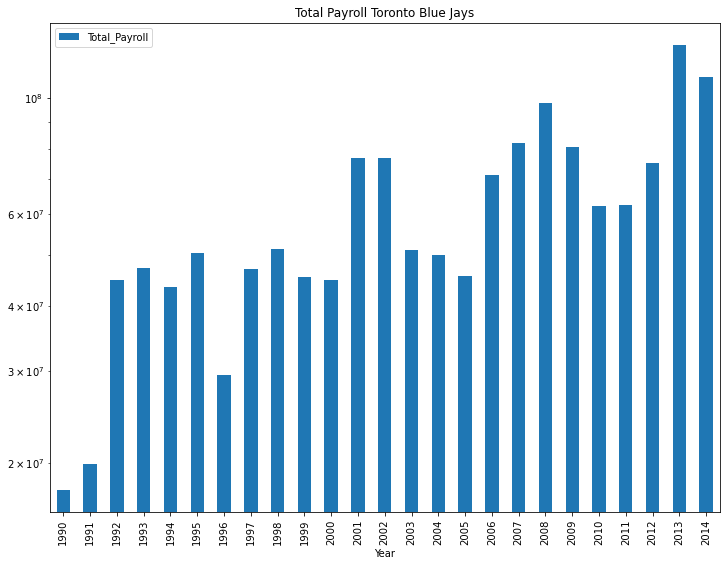

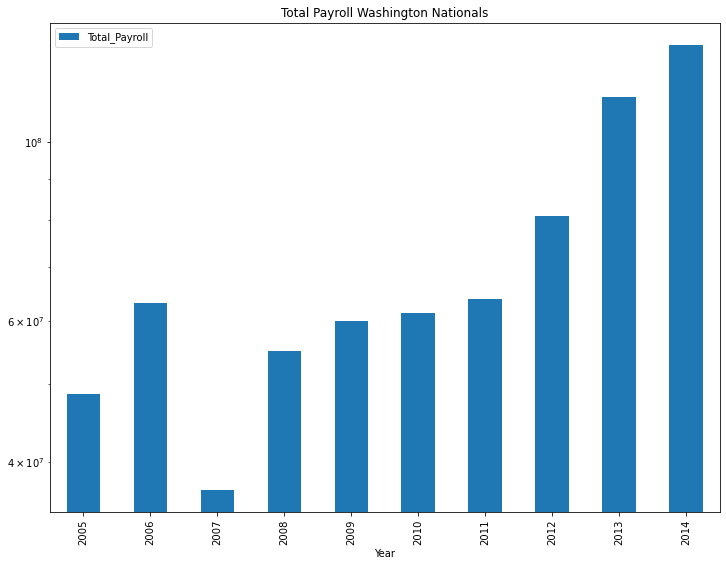

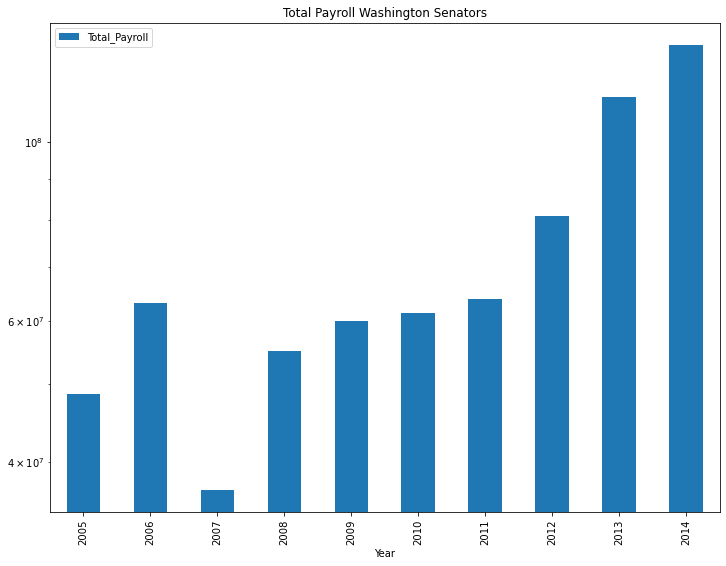

In [23]:
# number of result frames returned
num_results = len(result_frames_objects)

#prevents warning after 20 figures shown
plt.rcParams.update({'figure.max_open_warning':0})
figsize = (12,9)
for i in range(num_results):
    dfr = result_frames_objects[i]
    team_name = team_names[i]
    team_id = team_ids[i]
    #we only plot if the data frame in 
    #question is not empty
    if not dfr.empty: 
        dfr.plot(x='Year', y='Total_Payroll', logy=True, \
                  title = 'Total Payroll ' + team_name, kind='bar',figsize=figsize)
       
        #fig = plt.figure((i+1))
        #ax = fig.add_subplot(111)
        #image_name = 'figs/graph_{}_{}.png'.format(team_id, i)
        
        #fig.savefig(image_name)
        #plt.close(fig)

## Observations about the plots : 
### Over time, the payroll has increased for most of the teams.
### The average and total payroll have increased steadily over time.

Here is a plot of the sums and the average over the years for each team. The bar plots below show an increasing trend. We will plot the logarithm instead for the y axis. Just to show how the average and total payrolls are related to each other.

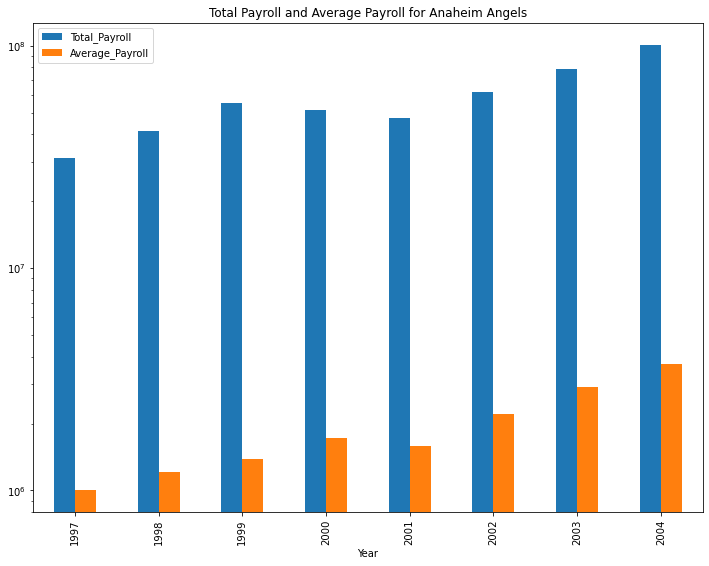

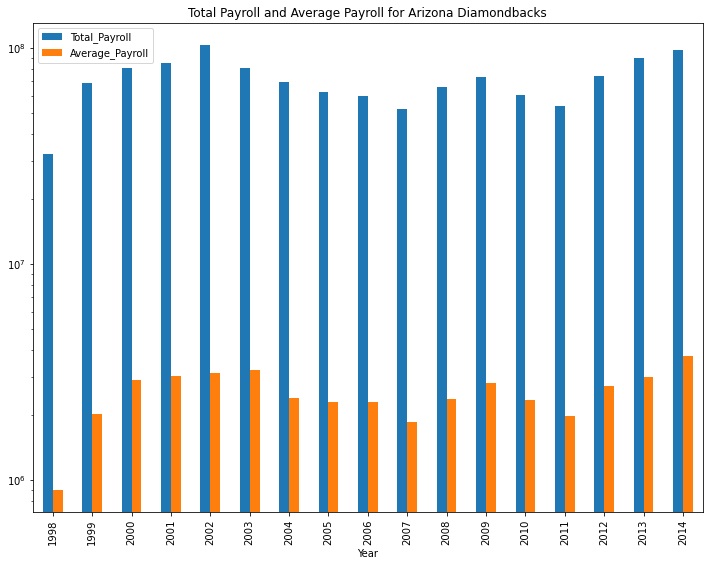

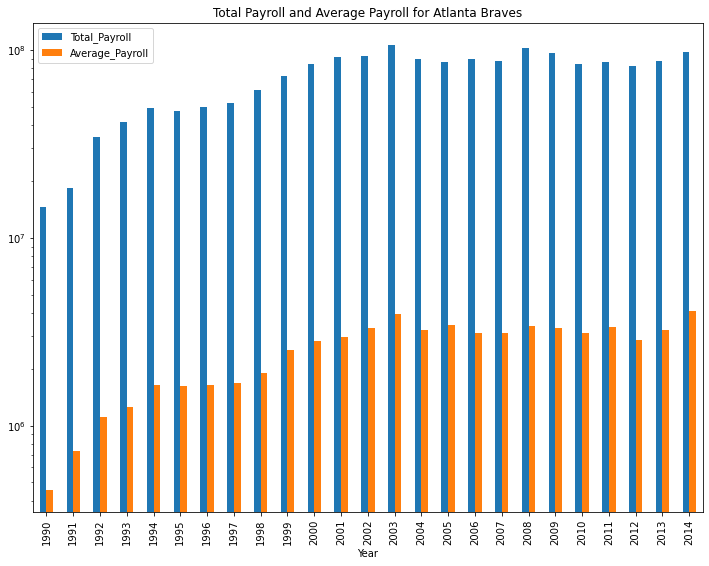

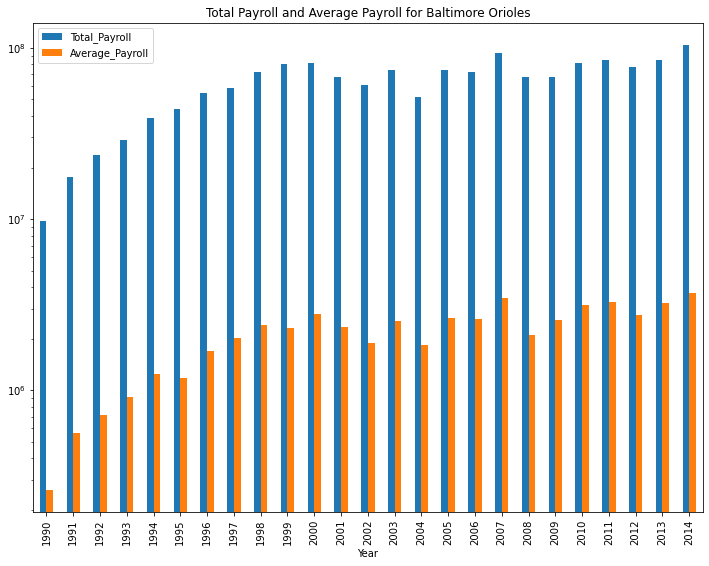

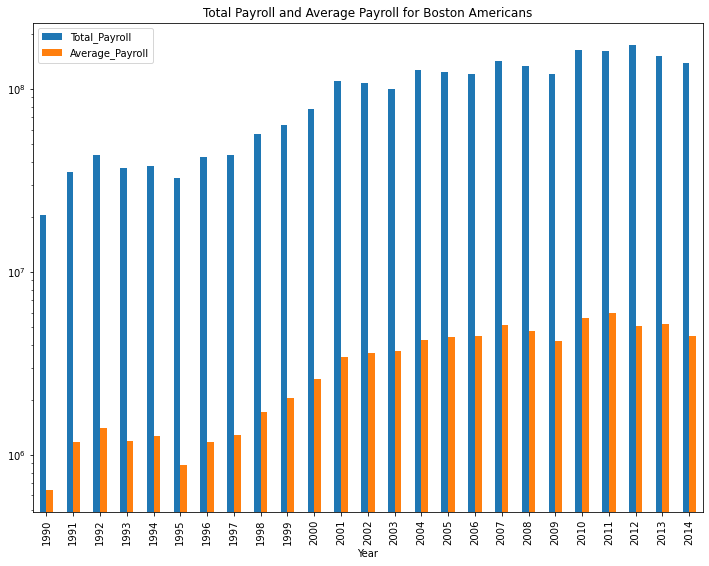

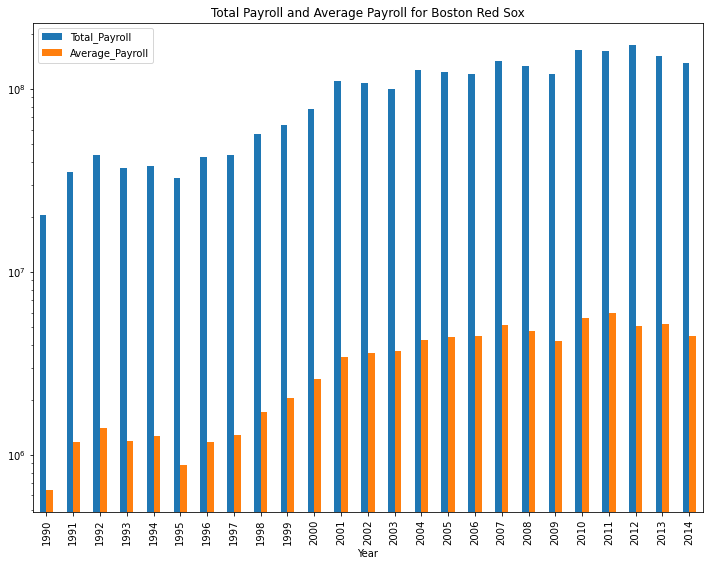

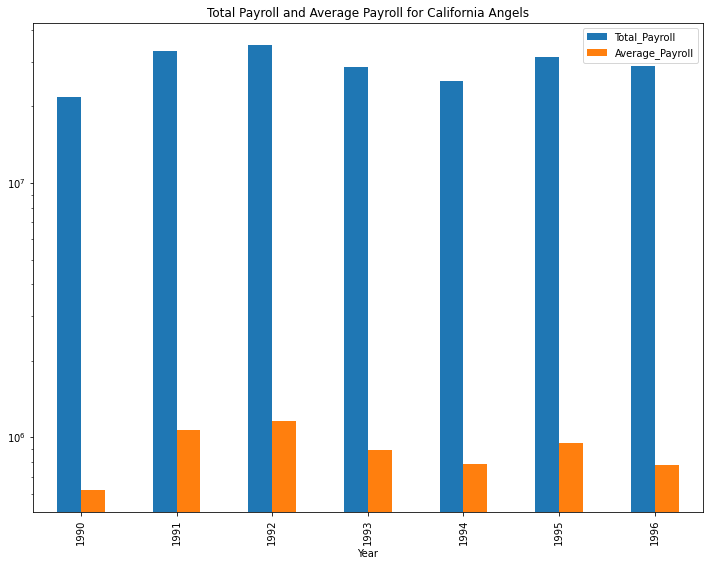

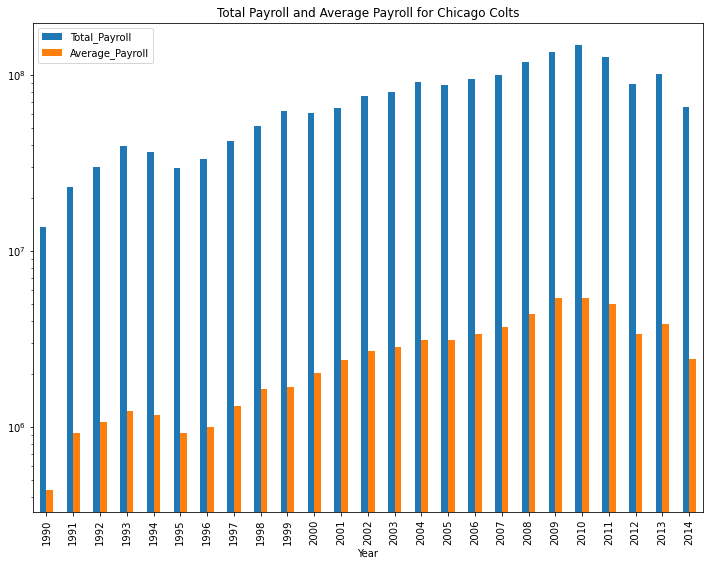

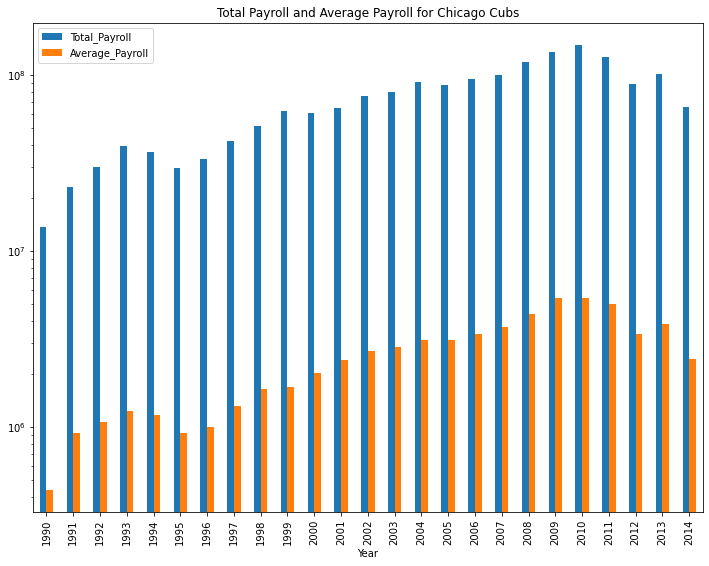

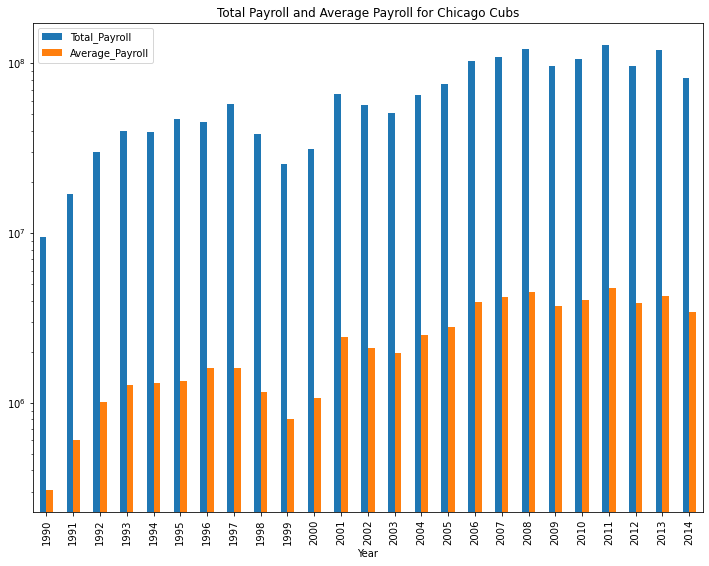

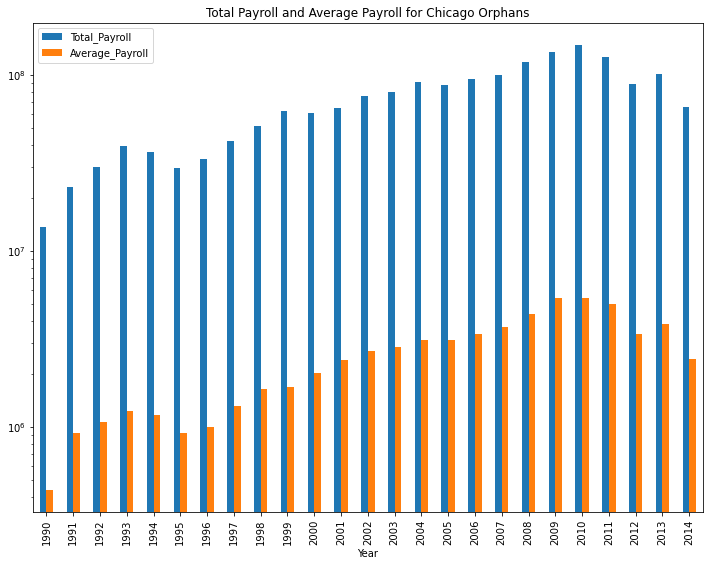

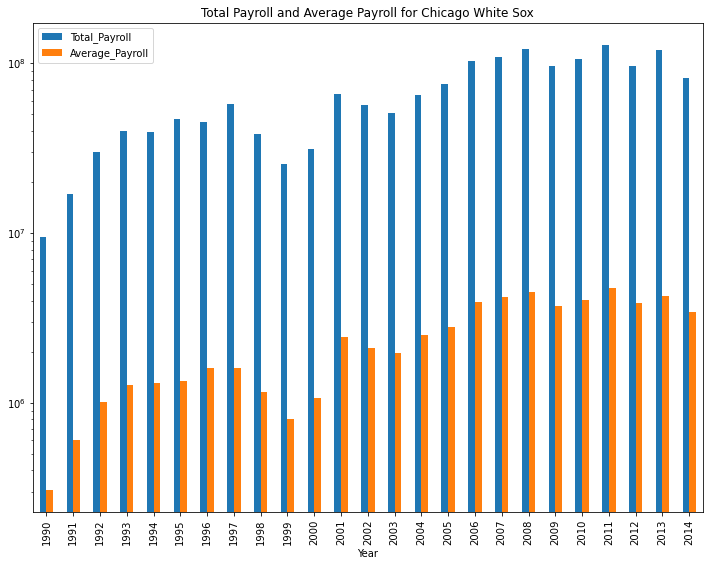

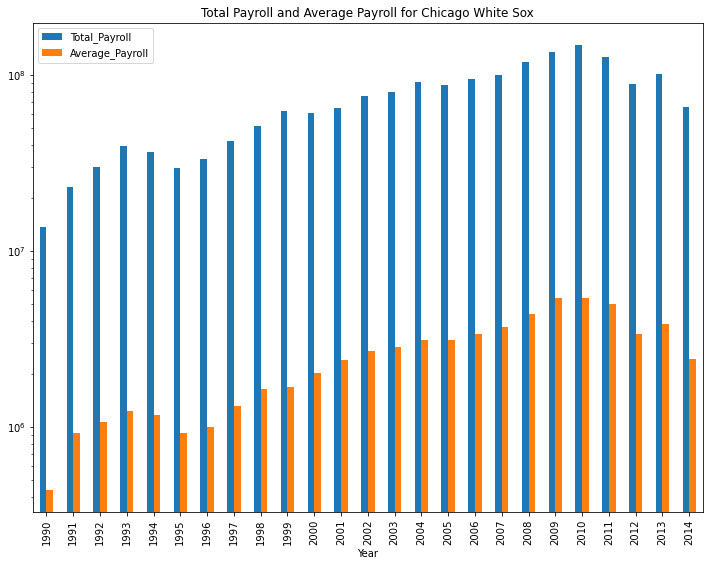

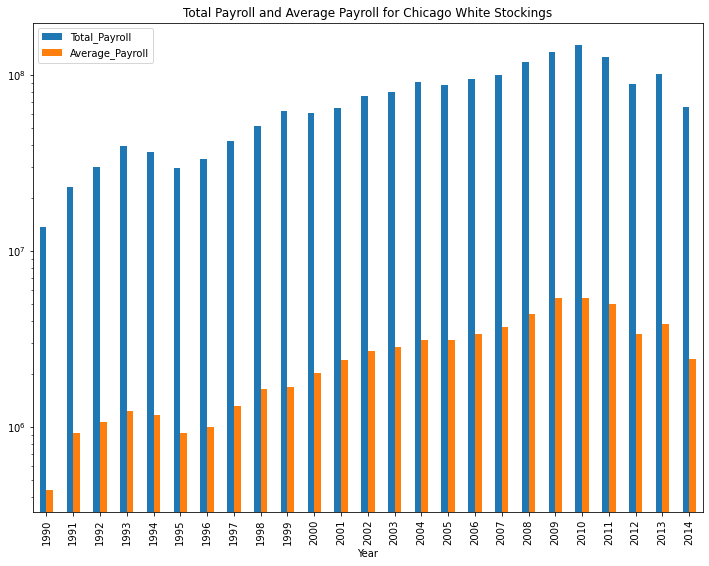

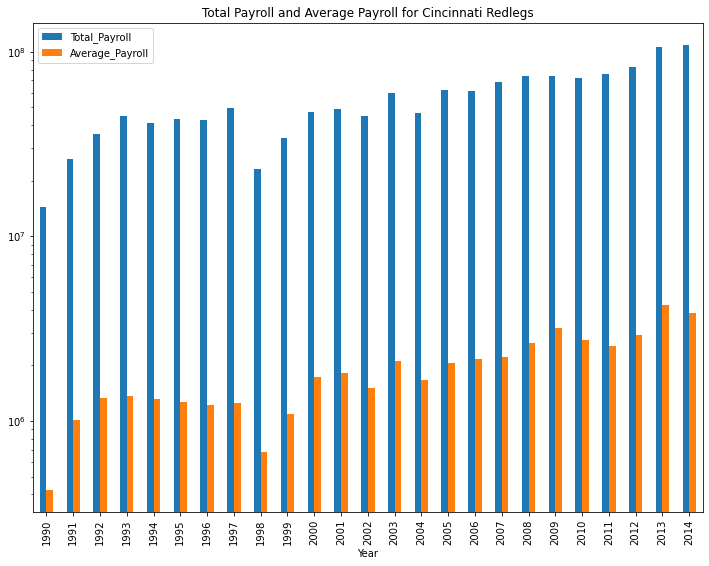

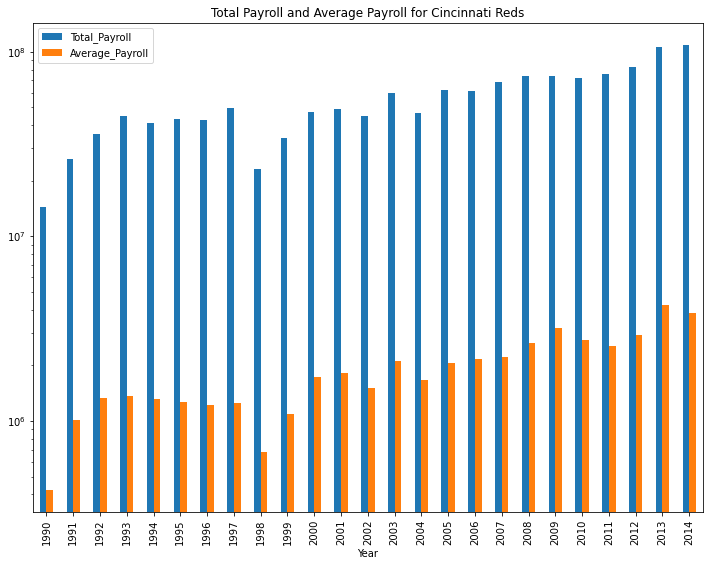

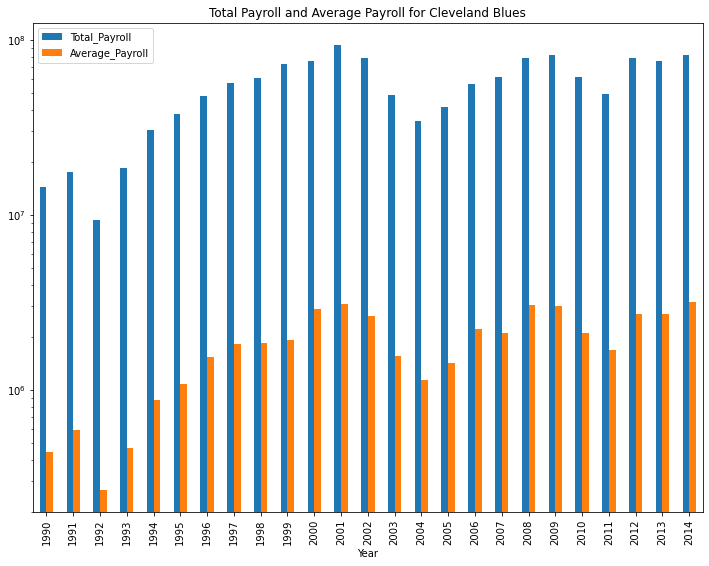

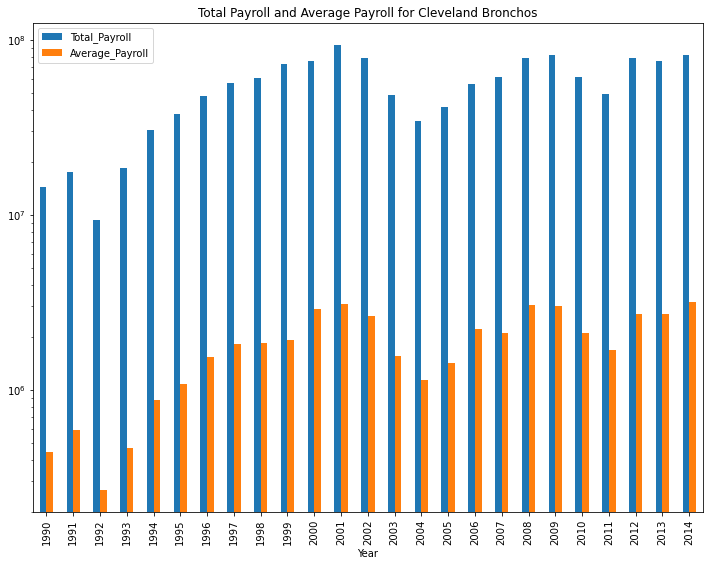

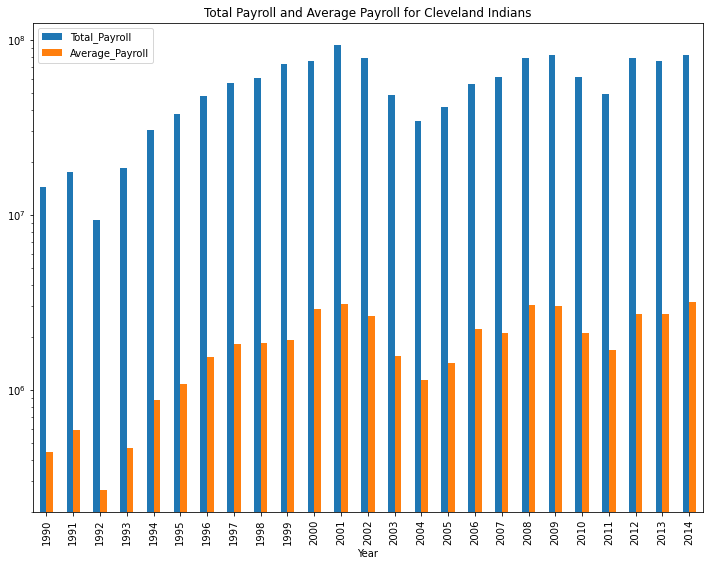

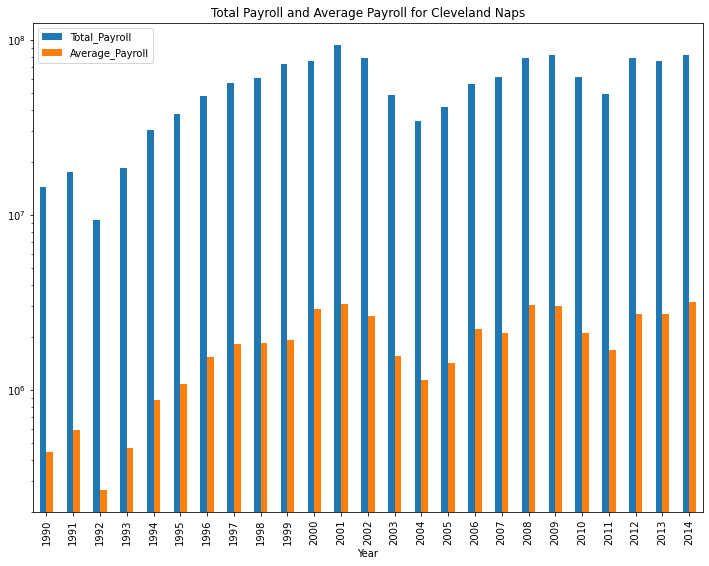

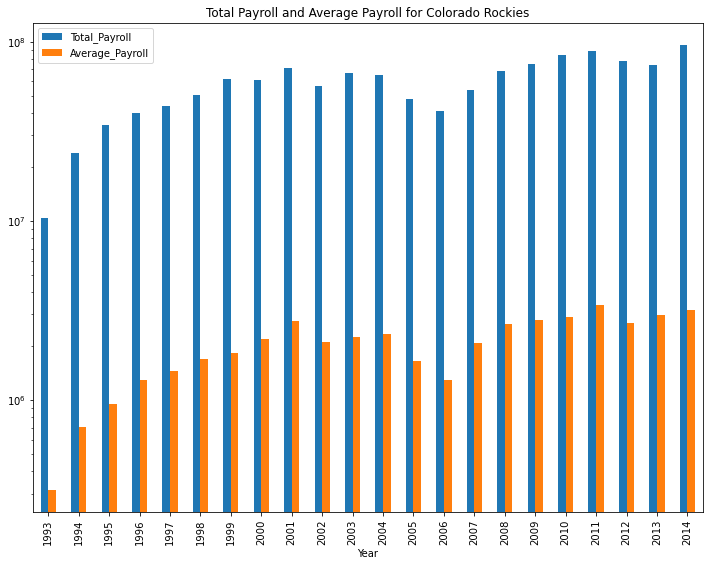

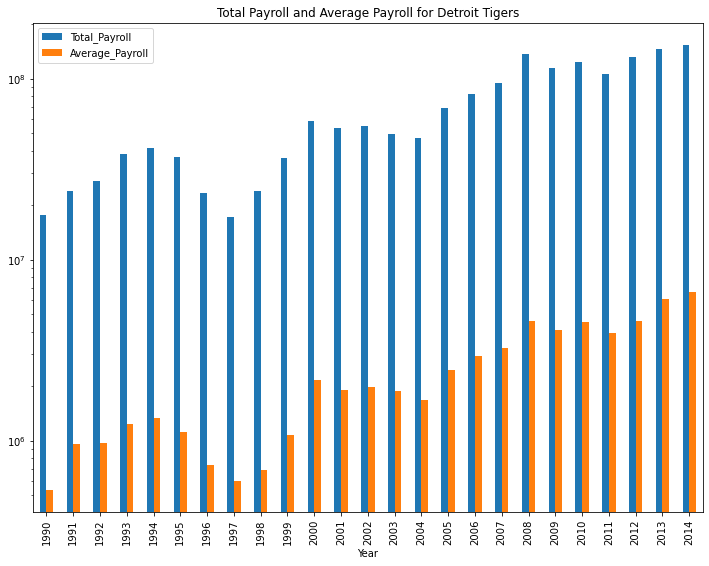

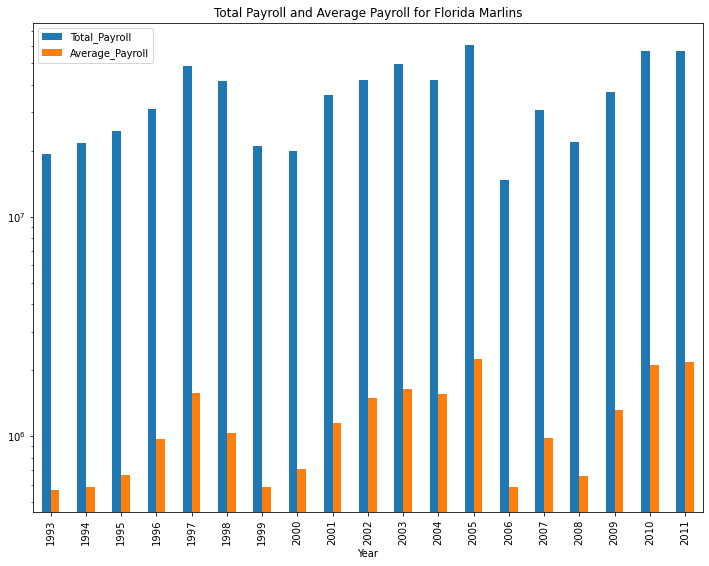

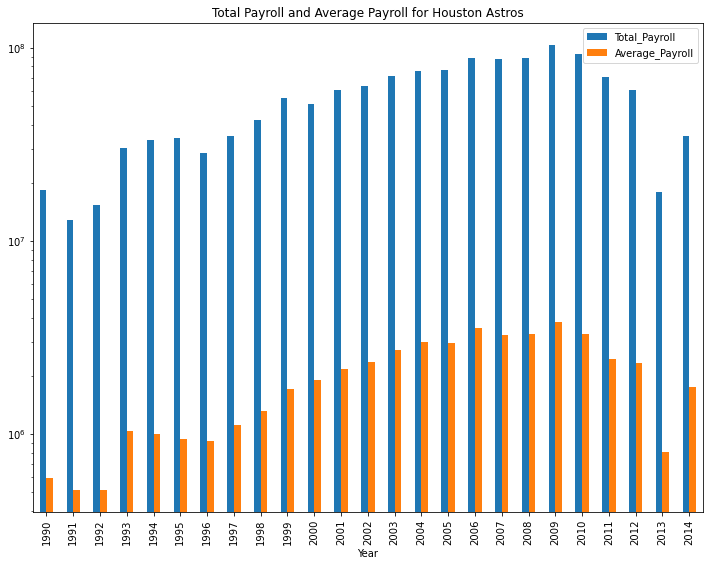

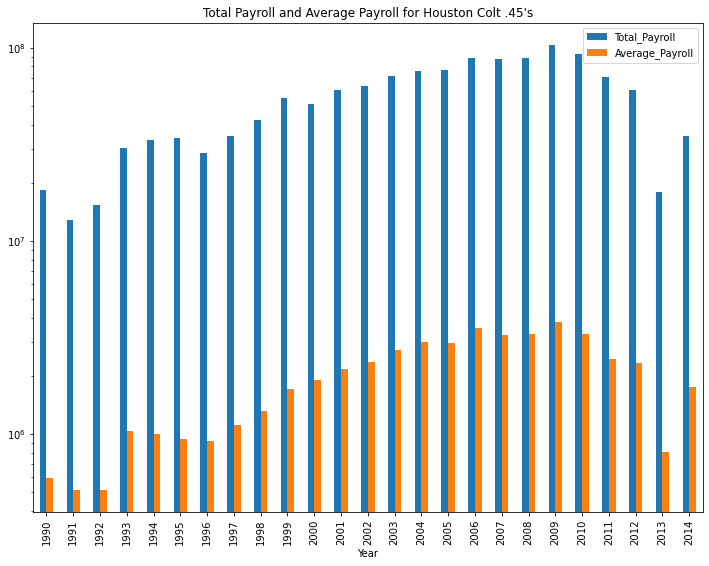

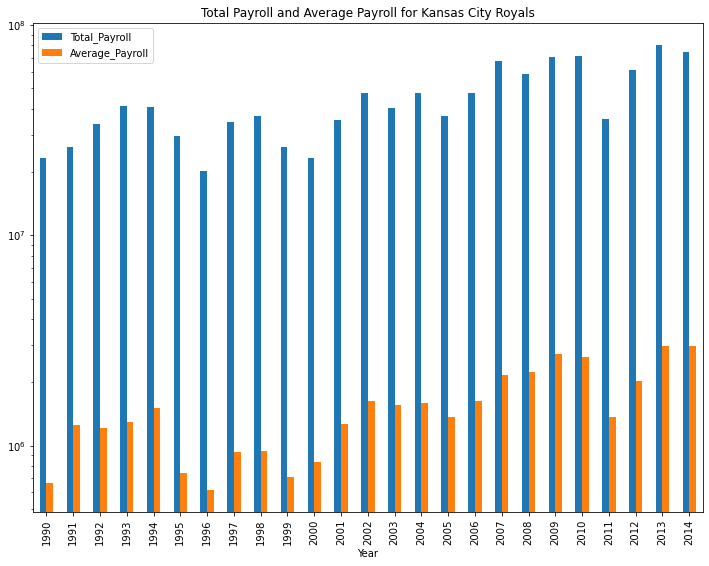

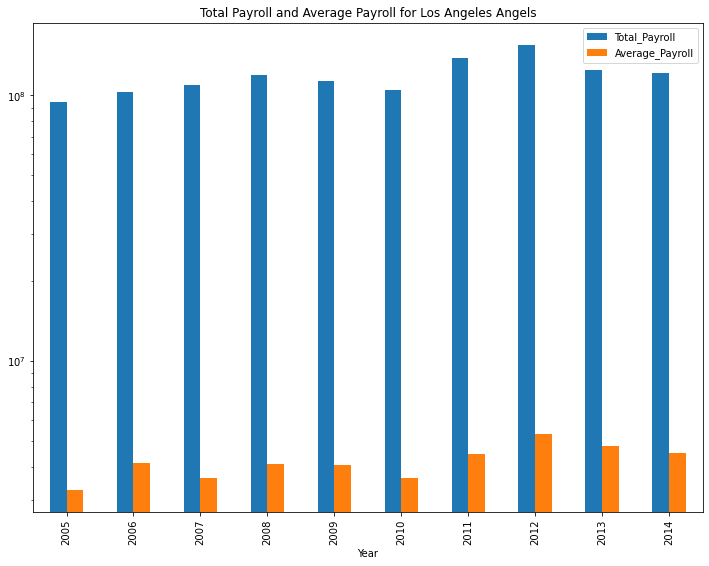

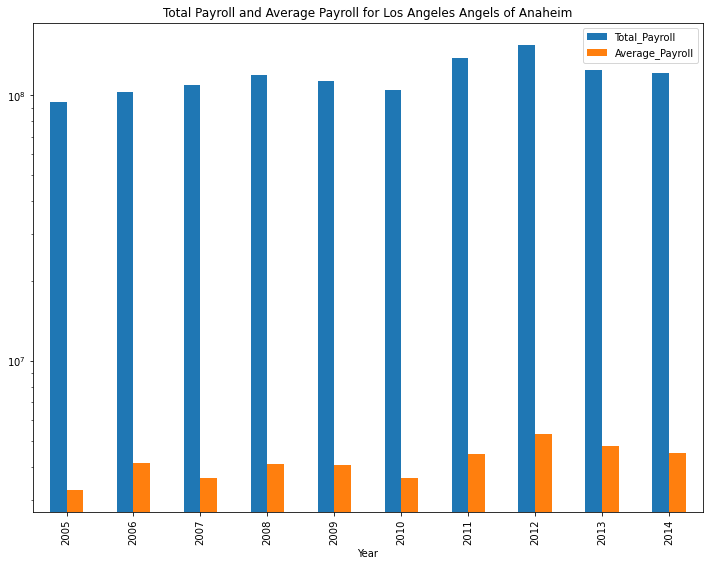

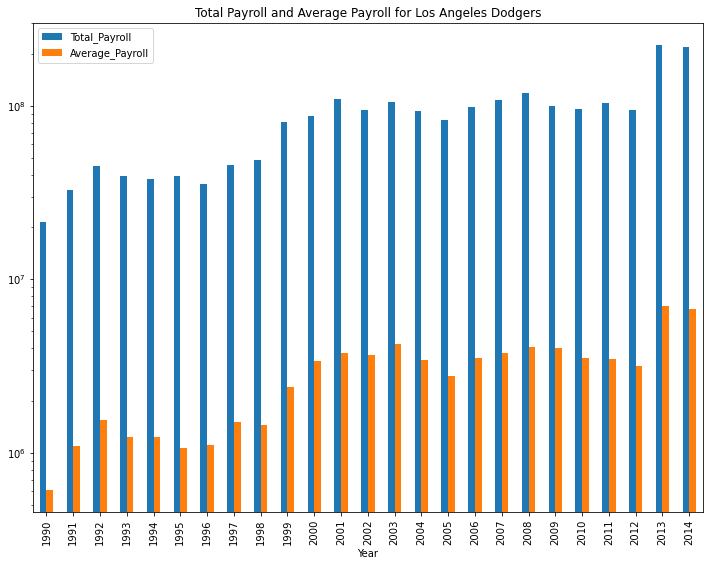

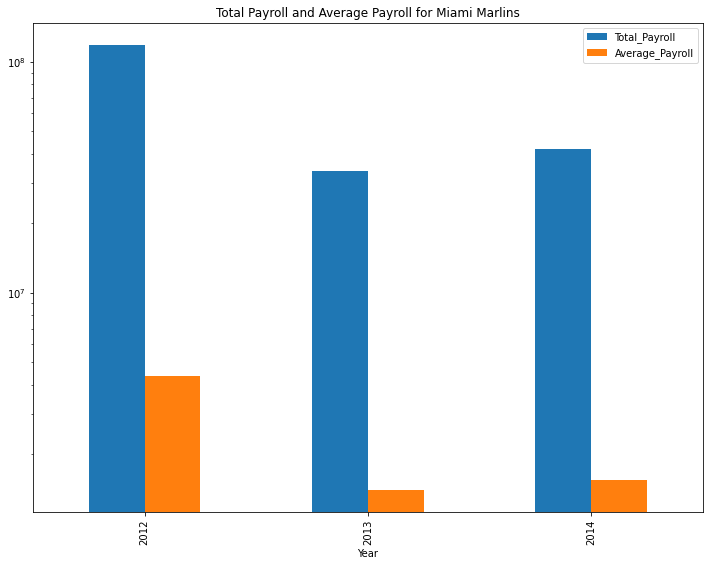

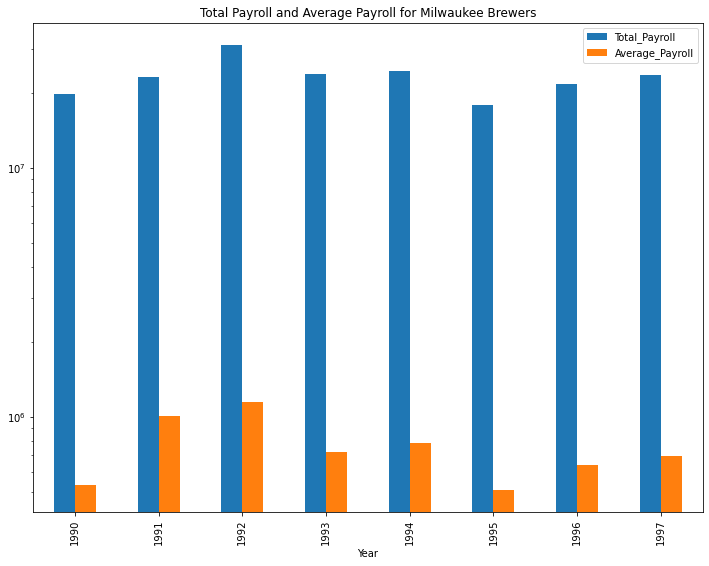

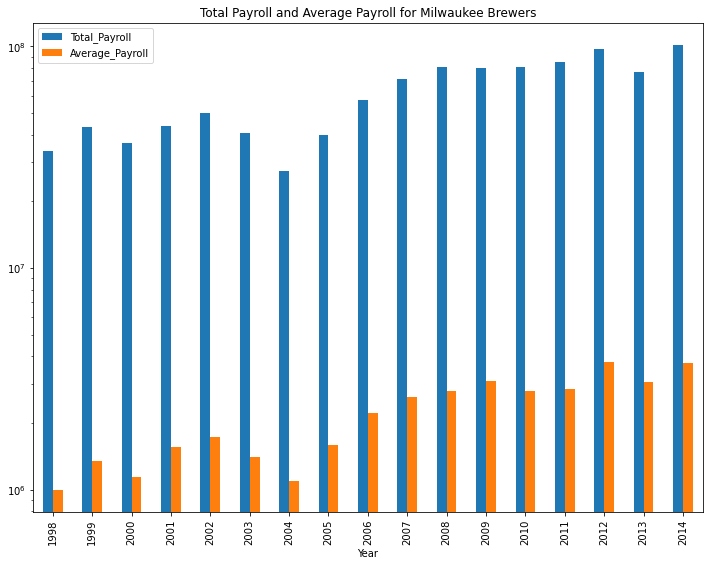

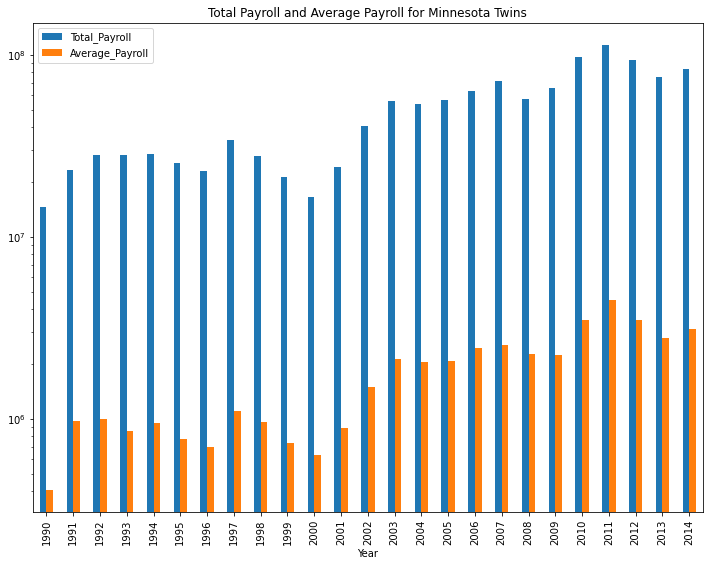

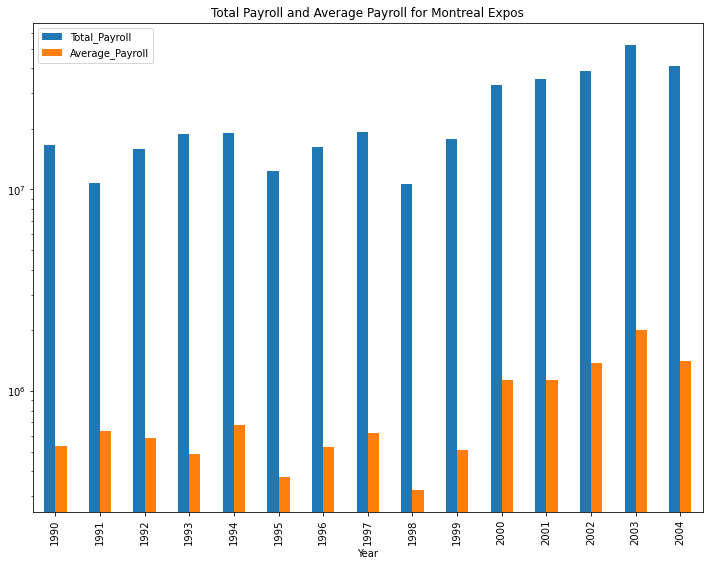

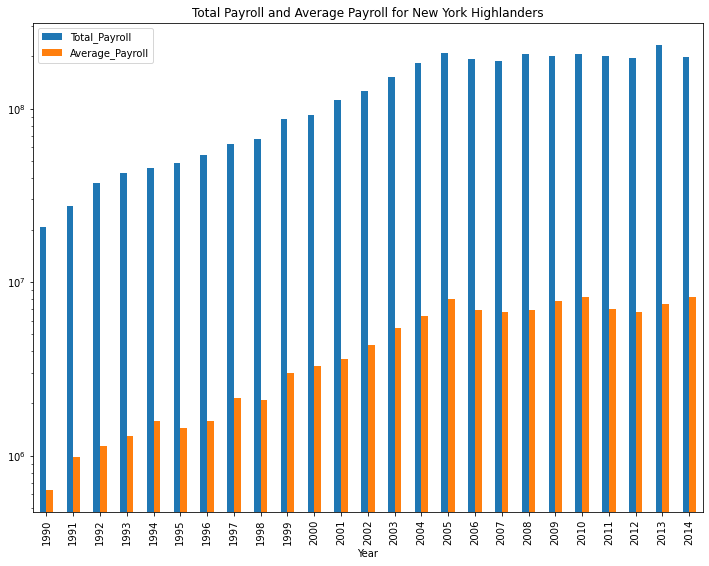

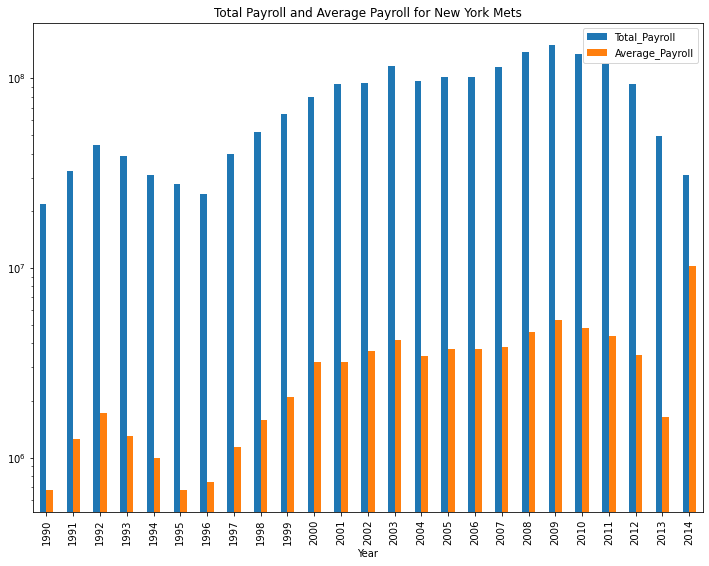

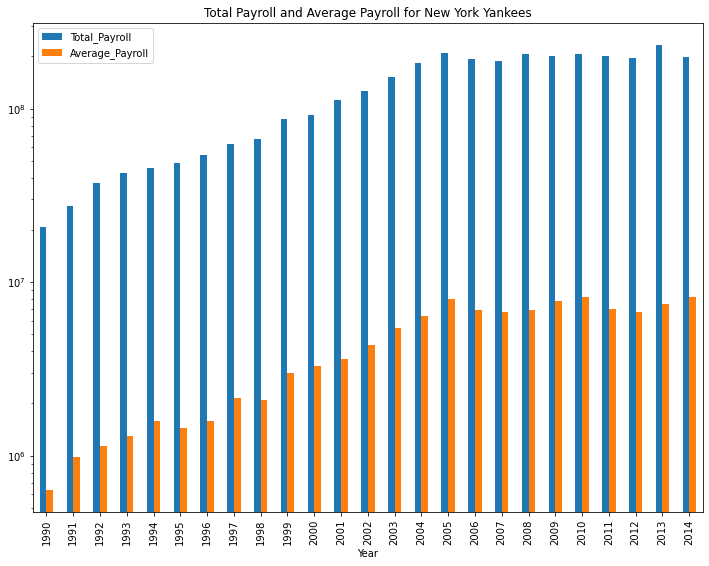

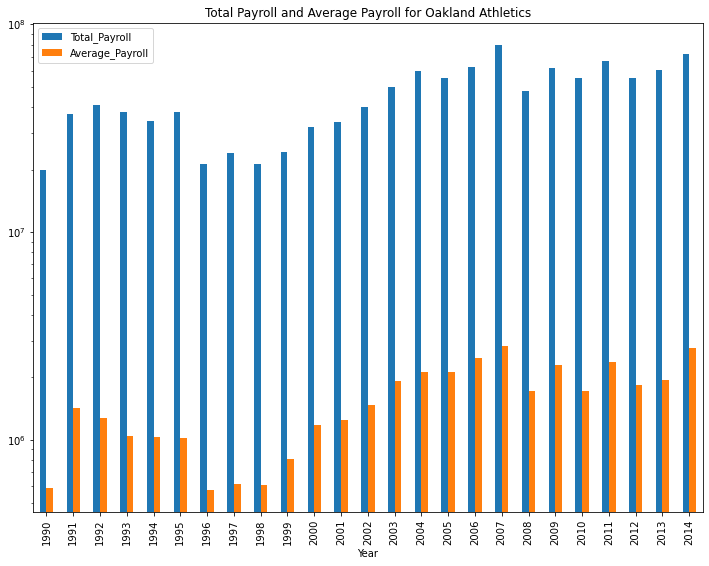

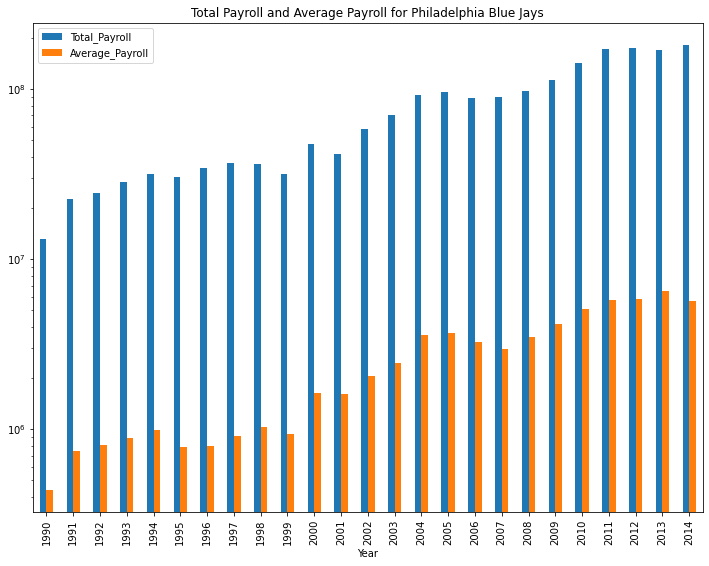

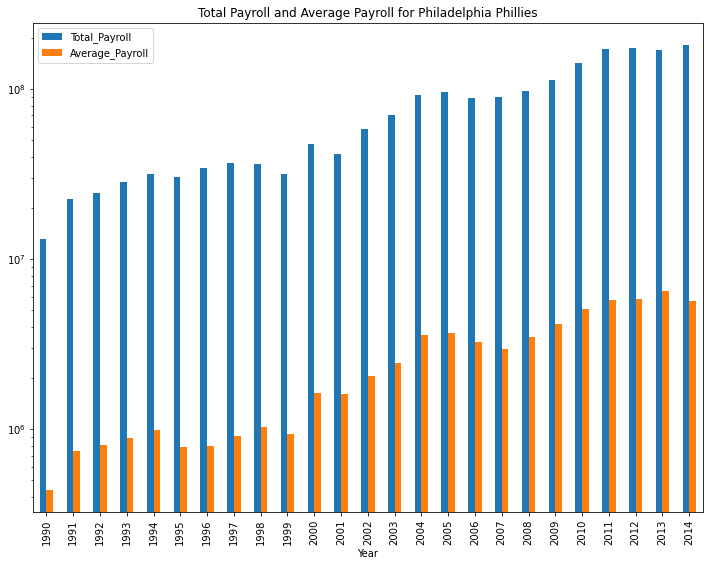

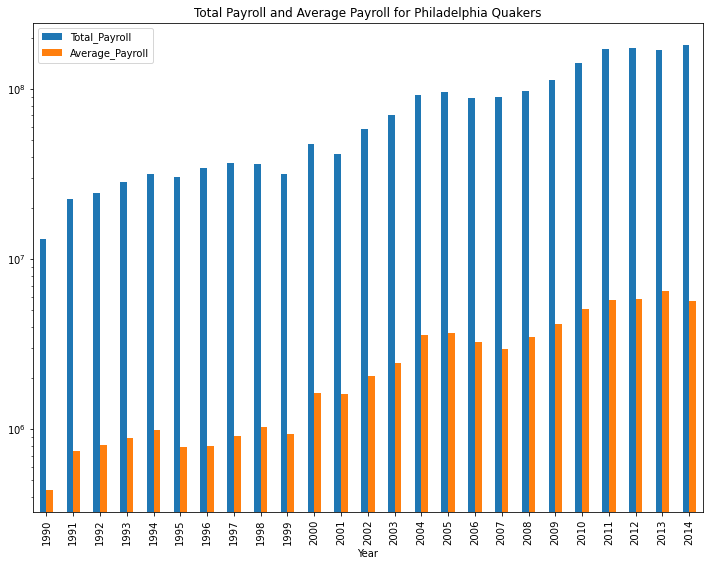

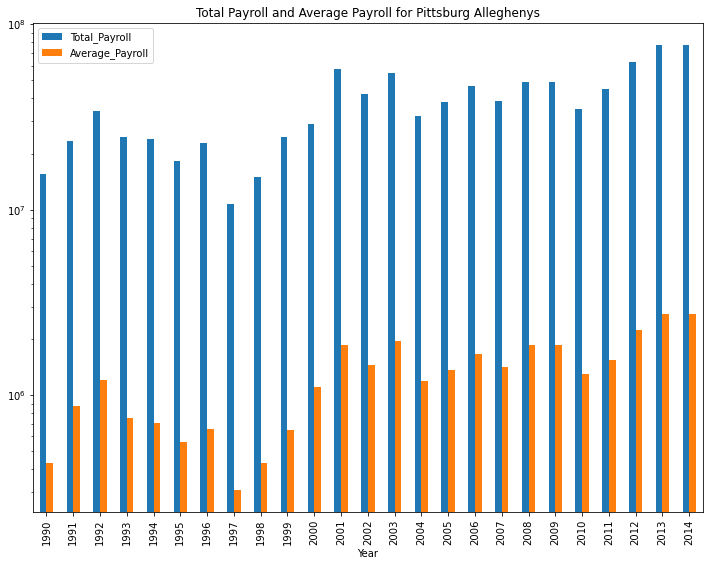

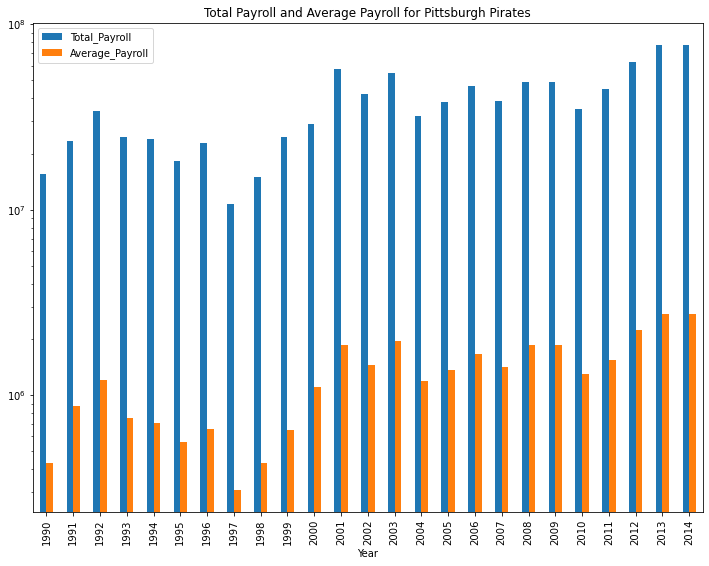

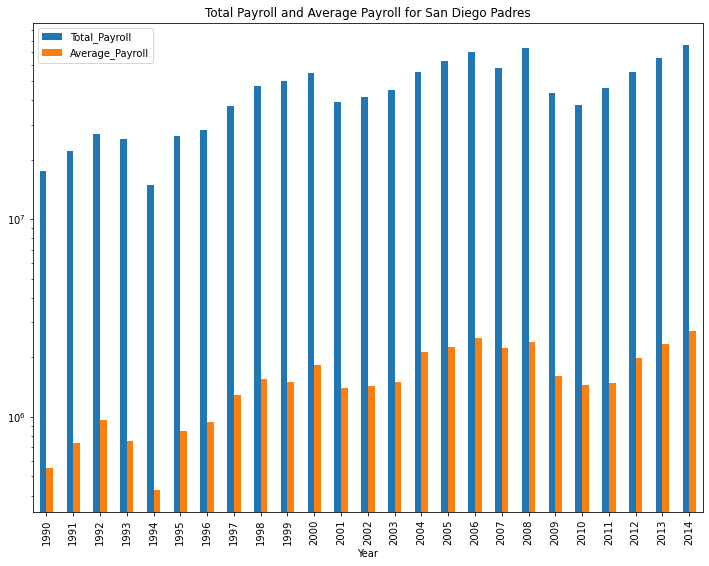

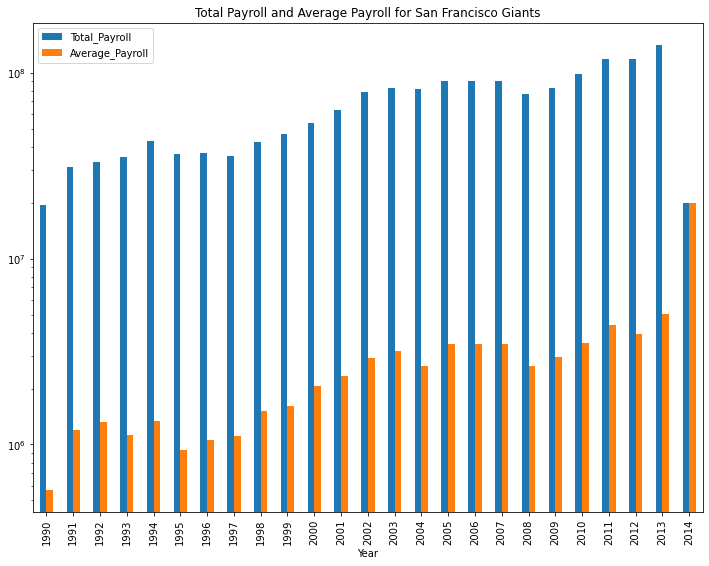

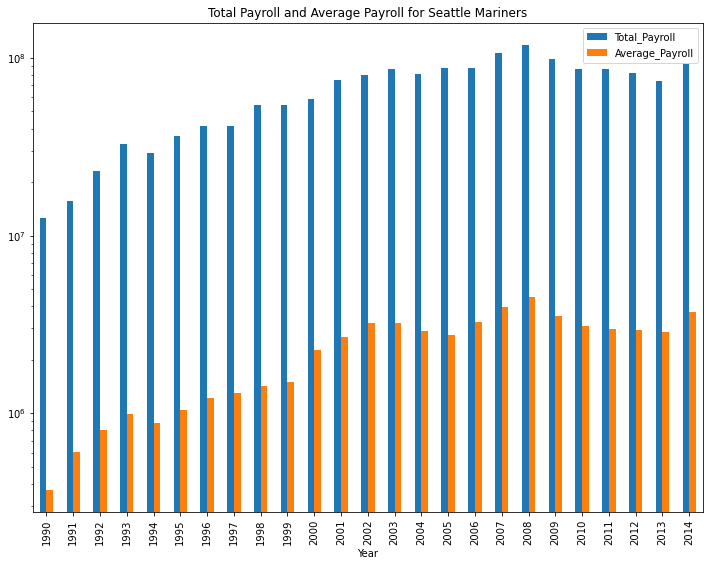

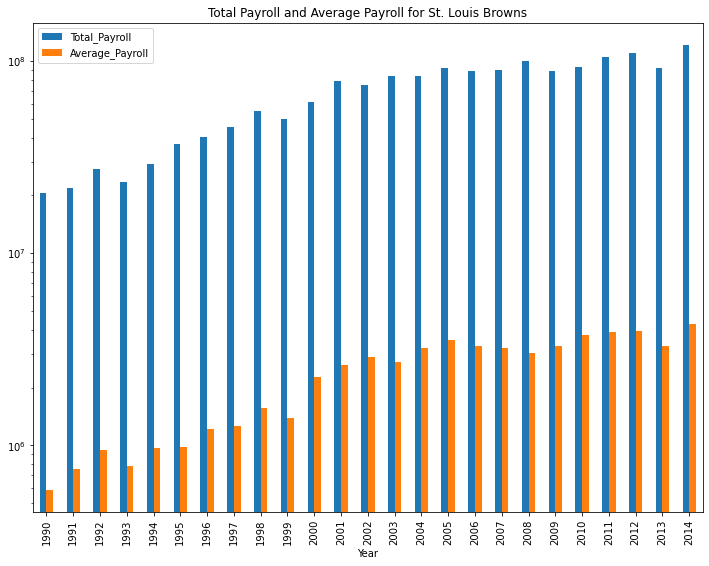

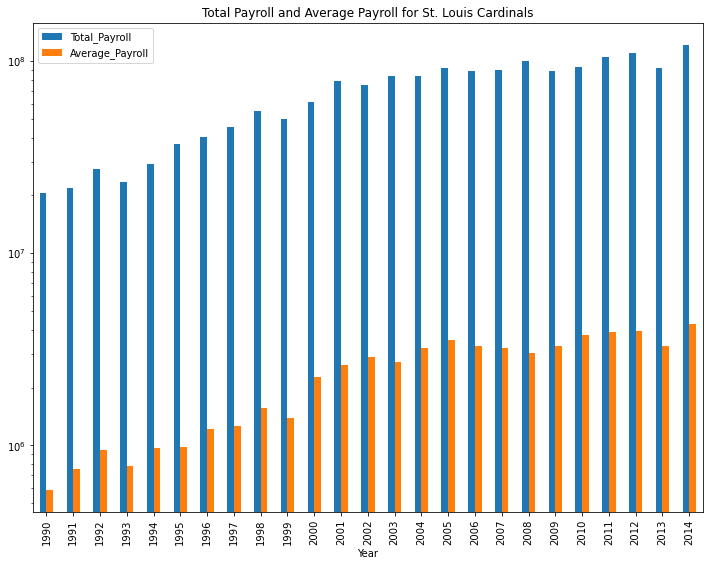

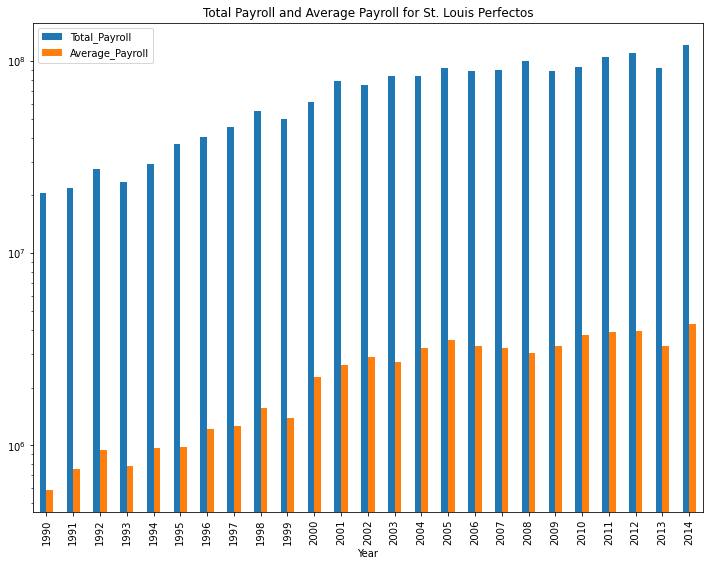

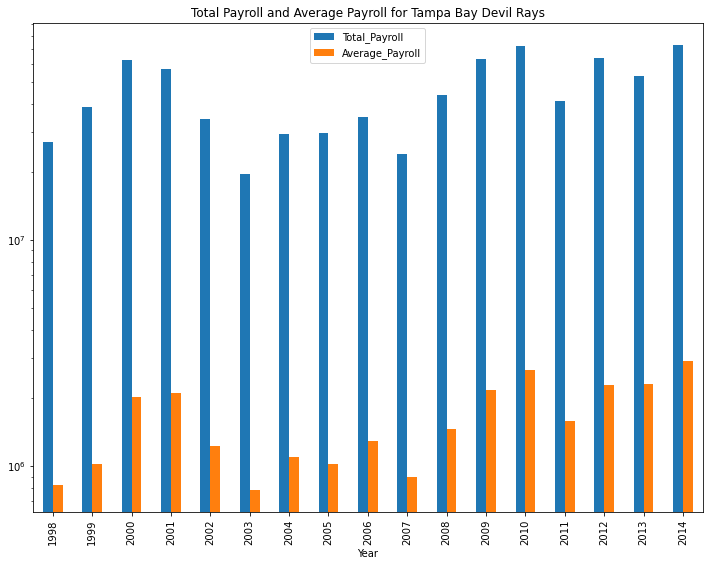

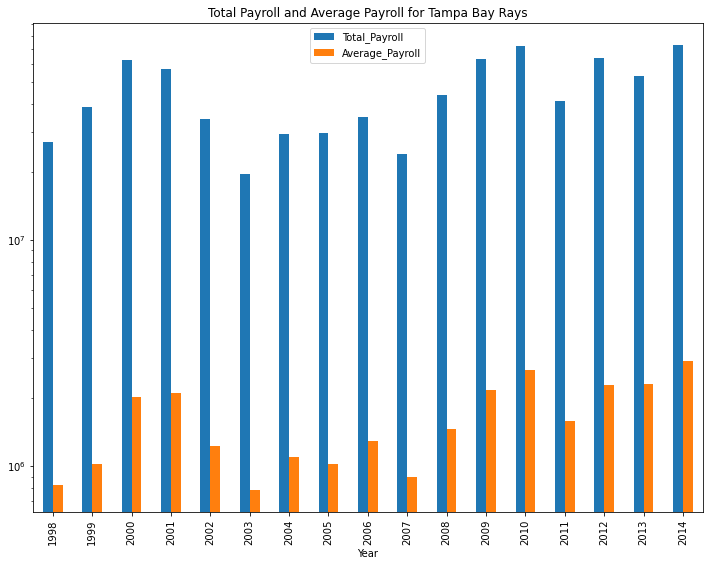

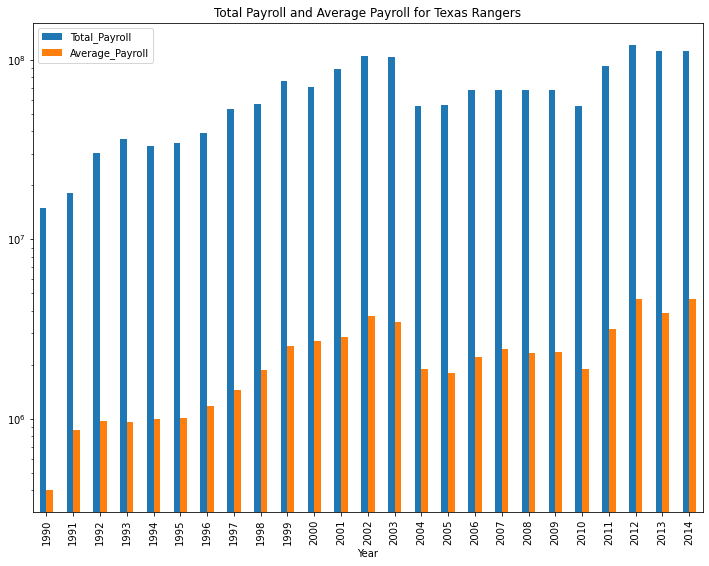

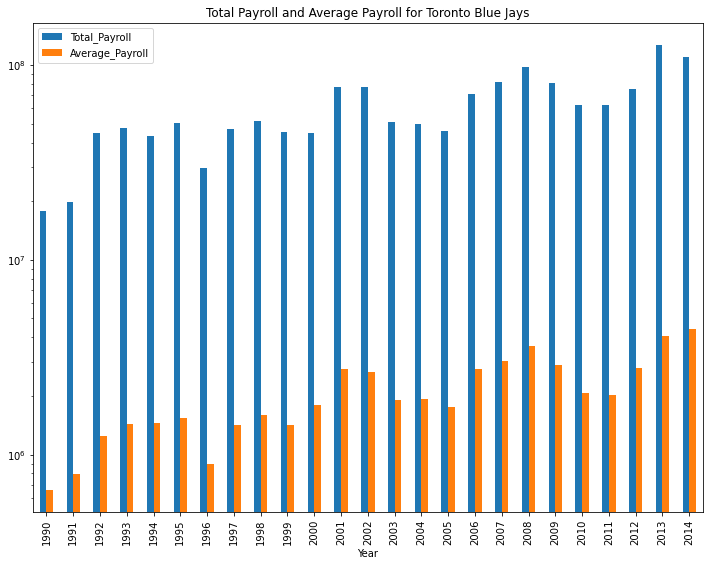

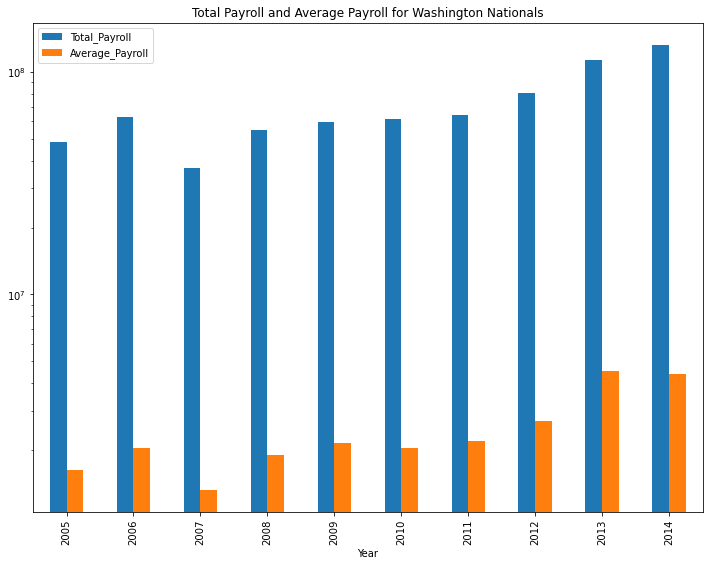

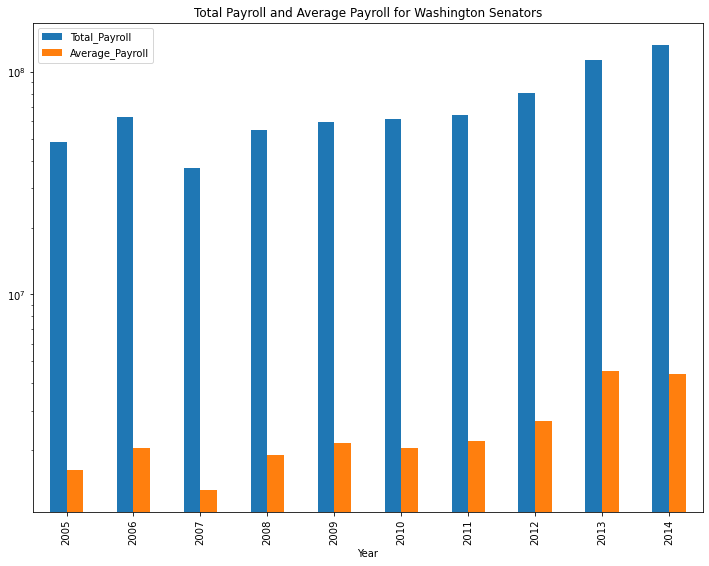

In [22]:

num_results = len(result_frames_objects)
#prevents warning after 20 figures shown
plt.rcParams.update({'figure.max_open_warning':0})
figsize = (12,9)
for i in range(num_results):
    dfr = result_frames_objects[i]
    team_name = team_names[i]
    team_id = team_ids[i]
    #we only plot if the data frame in 
    #question is not empty
    if not dfr.empty: 
        dfr.plot(x='Year',logy=True, y=['Total_Payroll','Average_Payroll'], \
                  title = 'Total Payroll and Average Payroll for ' + team_name, kind='bar',figsize=figsize)
       

The total payroll seems to be very high compared to the average payroll. However, the average here shows the averag salary paid to each player.

### ** Correlation between payroll and winning percentage **

We will first select the percentage winnings for each team for each year. Then we select the average and total payroll for each team over the years, and then join the results together.

In [19]:
winning_query = "SELECT teamID, yearID , " + \
        "printf('%5.2f%',(SUM(W)*1.0/(SUM(G)*1.0))*100.0) AS `PERCENTAGE WIN` " + \
        "FROM Teams " + \
        "GROUP BY teamID, yearID " + \
        "ORDER BY teamID, yearID "
winning_percentage_result = pandas.read_sql(winning_query, conn)
winning_percentage_result

,teamID,yearID,PERCENTAGE WIN
0,ALT,1884,24.00%
1,ANA,1997,51.85%
2,ANA,1998,52.47%
3,ANA,1999,43.21%
4,ANA,2000,50.62%
...,...,...,...
2770,WS8,1887,36.51%
2771,WS8,1888,35.29%
2772,WS8,1889,32.28%
2773,WS9,1891,31.65%


In [20]:
#payroll_query = "SELECT Salaries.teamID, Salaries.yearID, " + \
#        "AVG(Salaries.salary) AS `AVERAGE PAYROLL` " + \
#       "" + \
#        "FROM Salaries " + \
#        "GROUP BY teamID, yearID " + \
#        "ORDER BY teamID, yearID "

some_results = [] 
for team_id in team_ids :
    some_query = " SELECT Salaries.teamID, Salaries.yearID, " + \
        "(SUM(Teams.W)*1.0/(SUM(Teams.G)*1.0))*100.0 AS `PERCENTAGE WIN`, " + \
        "AVG(Salaries.salary) AS `AVERAGE PAYROLL`, " + \
        "SUM(Salaries.salary) AS `TOTAL PAYROLL` " + \
        "FROM Salaries " + \
        "LEFT JOIN Teams ON Salaries.teamID = Teams.teamID " + \
        "WHERE Salaries.teamID = '" + team_id + "' " + \
        "GROUP BY Salaries.teamID, Salaries.yearID " + \
        "ORDER BY Salaries.teamID, Salaries.yearID "
    v = pandas.read_sql(some_query, conn)
    some_results.append(v)

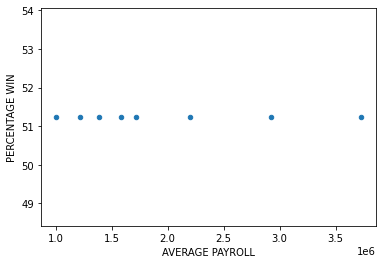

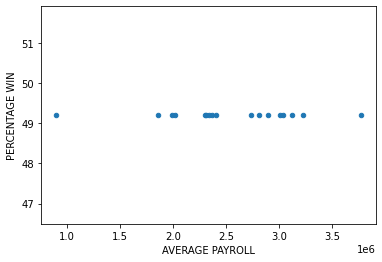

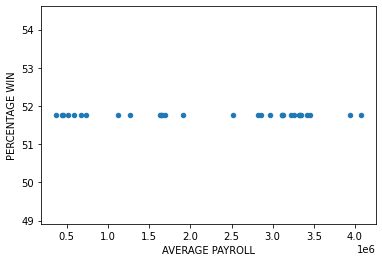

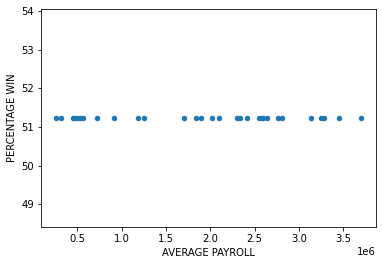

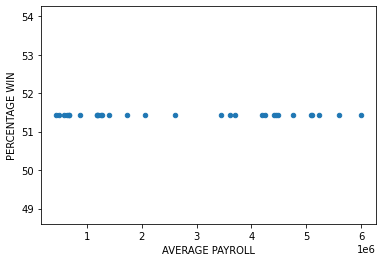

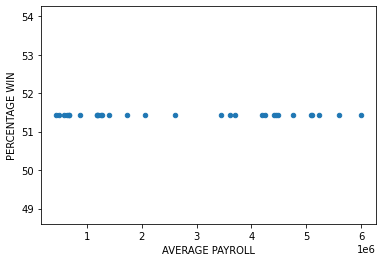

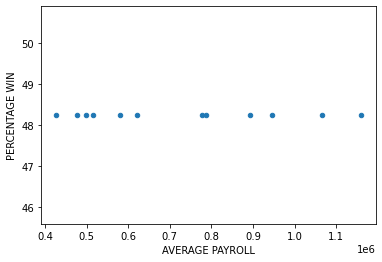

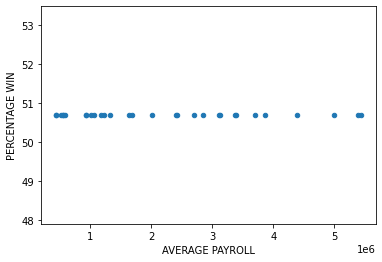

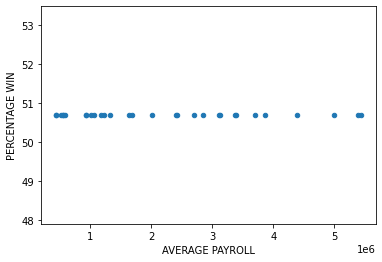

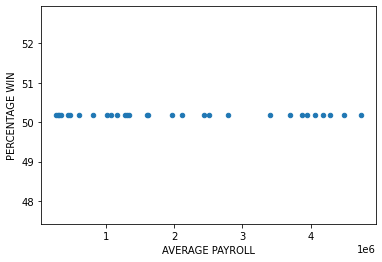

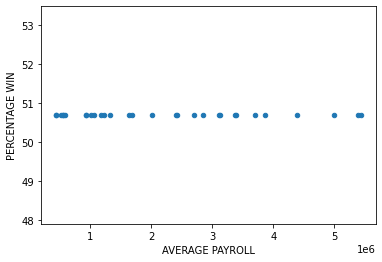

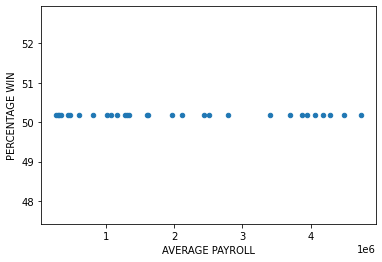

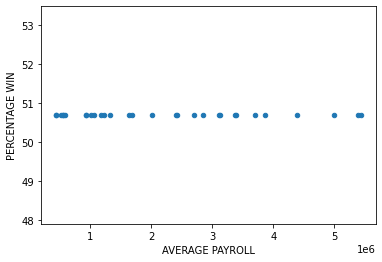

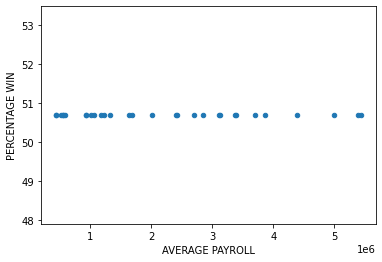

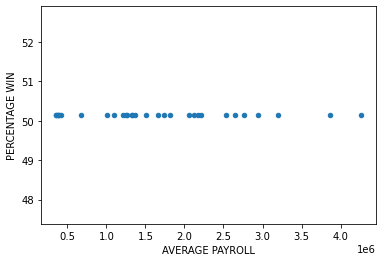

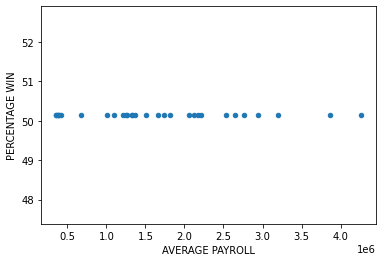

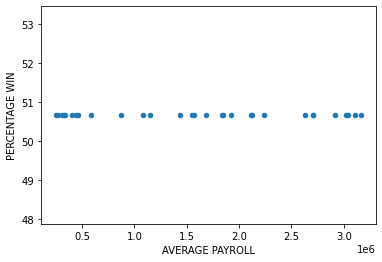

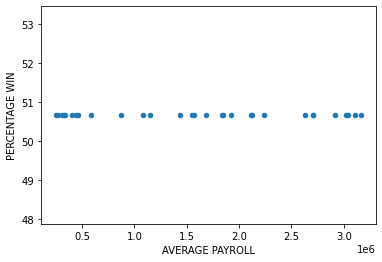

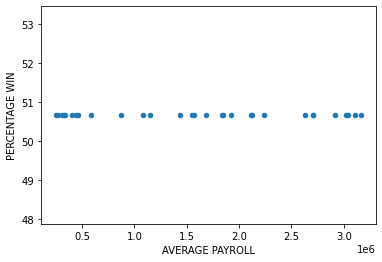

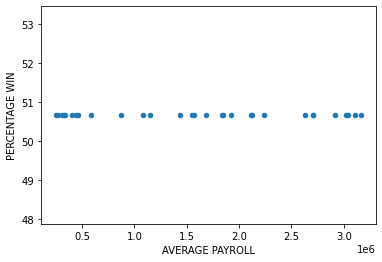

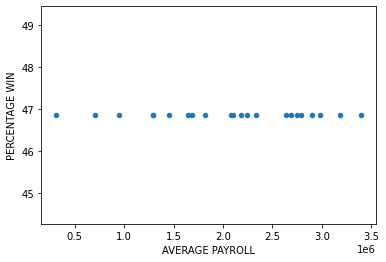

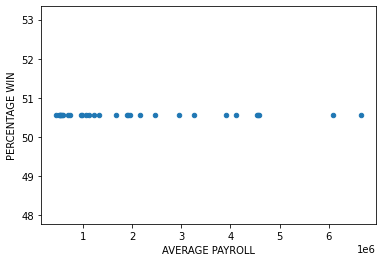

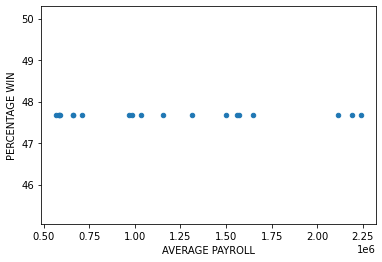

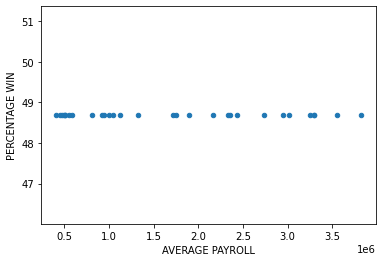

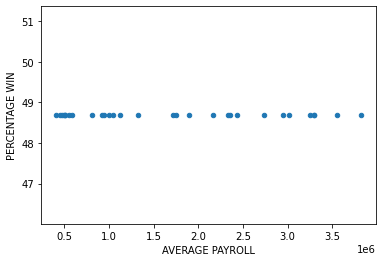

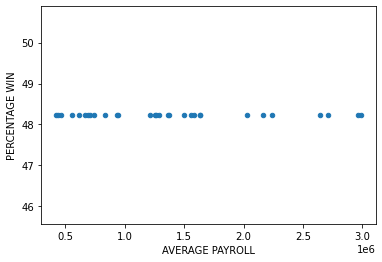

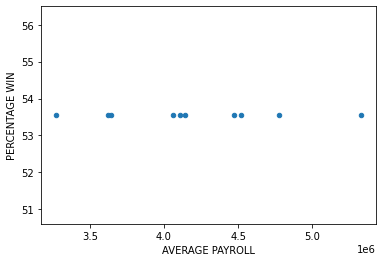

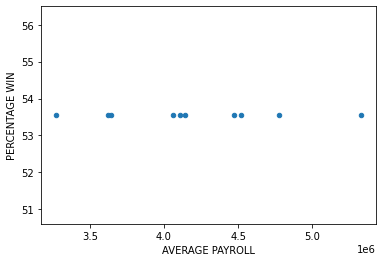

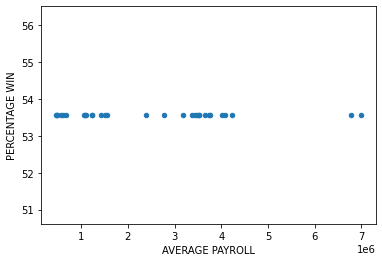

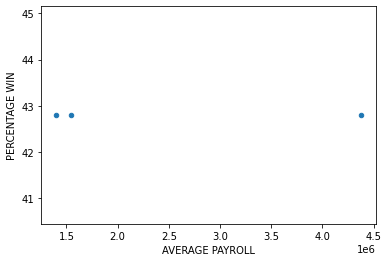

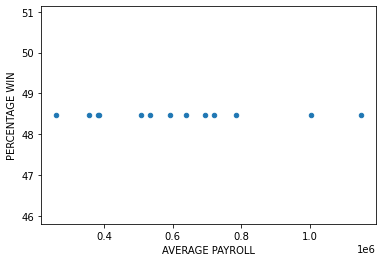

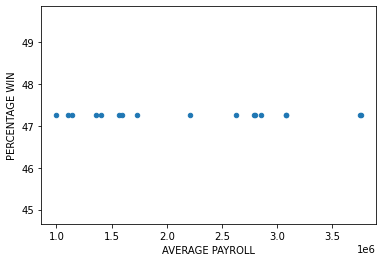

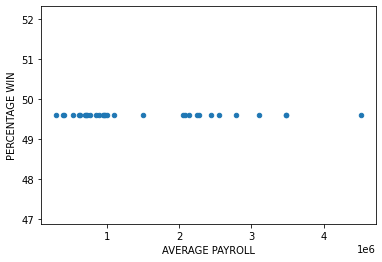

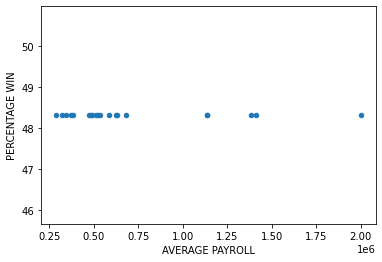

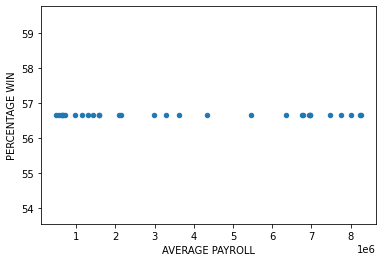

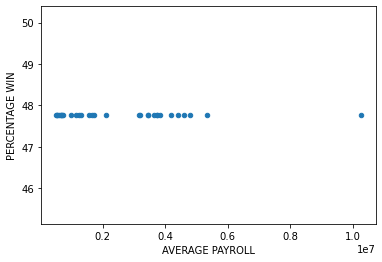

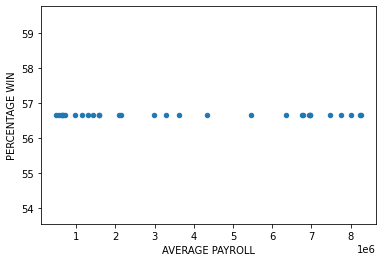

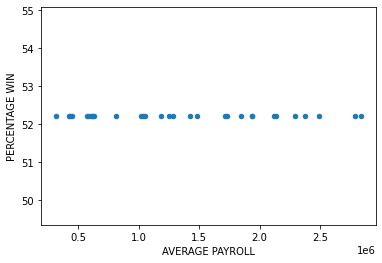

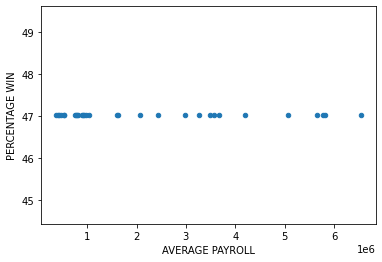

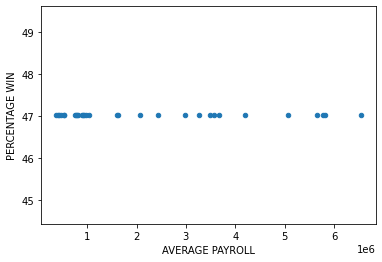

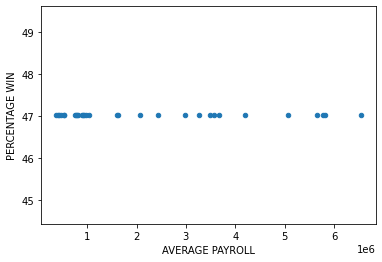

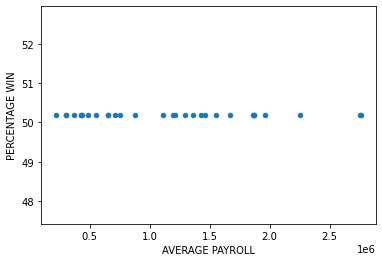

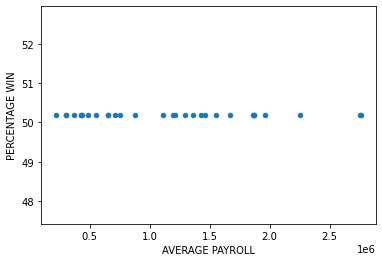

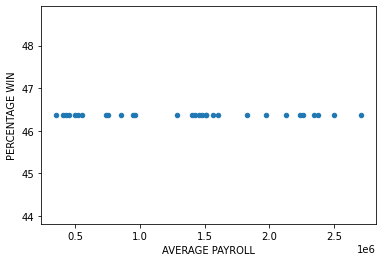

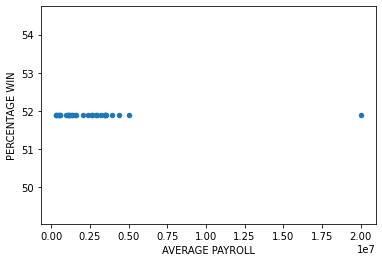

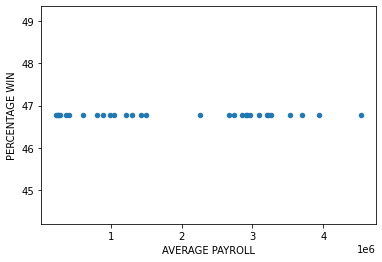

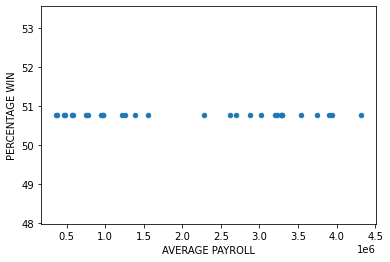

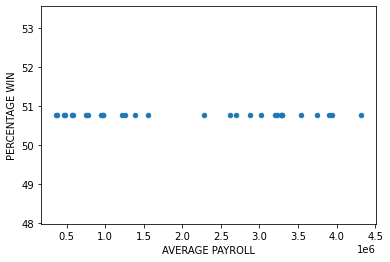

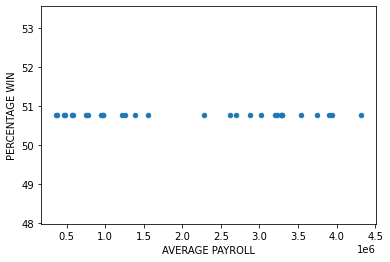

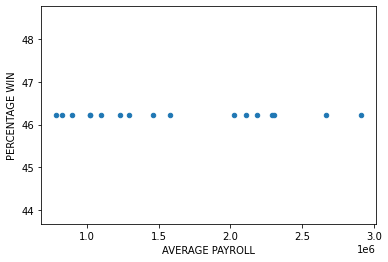

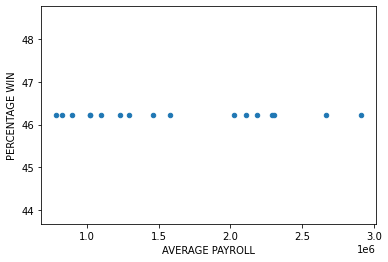

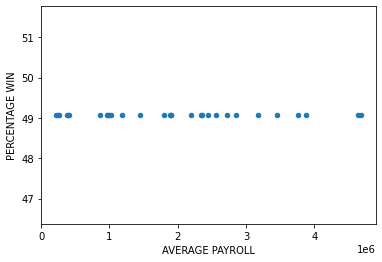

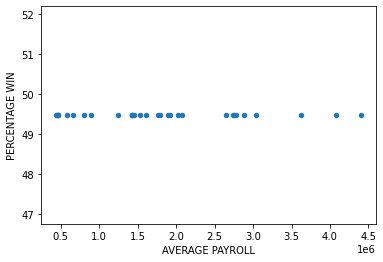

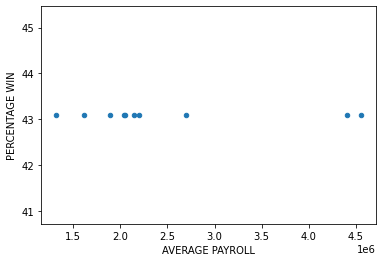

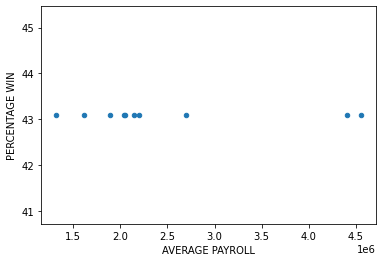

In [21]:
for index in range(len(some_results)):
    r = some_results[index]
    if r.empty == False:
        r.plot(x='AVERAGE PAYROLL', y='PERCENTAGE WIN', kind='scatter')
        